In [1]:
# Window
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))

# Nonlocal Misfit Scalar Regularization Parameter $\lambda$ Optimization for Training with datasets

<div class="alert alert-block alert-danger">
These notebooks are better visualized using codefolding from Jupyter 
    <a href="https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/">extensions</a>.

This code was built using `numpy 1.26.4`, `pandas 2.2.3`, `scipy 1.15.1`.
</div>

In [1]:
# Packages
import numpy  as np
import pandas as pd
import scipy.sparse as sparse
from scipy       import version as sp_v
from collections import deque

import numba
from   numba import jit

import time
import itertools

from   skimage.metrics   import structural_similarity as ssim
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline
import matplotlib.pyplot as plt

import skimage.io    as io
import skimage.color as color
from   skimage              import data_dir
from   skimage.transform    import resize
from   mpl_toolkits.mplot3d import Axes3D
from   matplotlib           import cm
from   matplotlib.ticker    import LinearLocator, FormatStrFormatter, MultipleLocator
from   pathlib              import Path

In [2]:
print('NumPy: {0}, Pandas: {1}, SciPy: {2} '.format(np.__version__, pd.__version__, sp_v.full_version))

NumPy: 1.26.4, Pandas: 2.2.3, SciPy: 1.15.1 


<div class="alert alert-block alert-success">
We solve the following spatial nonlocal bilevel problem:
\begin{align*}
        &\min \dfrac{1}{2N} \sum_{i=0}^{N-1} \|u_i-u_i^T\|^2_{0,\Omega} 
    \\
    \text{subject to}\qquad
    \\
        & (u_i,\phi)_{V_i} + \big( \lambda(u_i-f_i), \phi \big) = 0, &\forall \phi \in V_i, i\in [0:N-1].
\end{align*}
</div>

$\DeclareMathOperator{\AK}{\mathrm{AK}_\sigma}$
The nonlocal product $(u,\phi)_V$ is defined as
\begin{align}
    (u,\phi)_V = ( u \AK \mathbb{1} - \AK u, \phi )_{L^2(\Omega)}.
\end{align}
Here $\AK$ represents the unnormalised _extended Gaussian ANOVA kernel_, which in turn is given by:
\begin{align}
    \AK u (x) = \sum_{\ell=1}^L \frac{1}{\sf L} \int_\Omega u(y)\, e^{-\sigma^{-2} \big\| \mathcal{W}_\ell [f](x) - \mathcal{W}_\ell [f](y) \big\|^2}  \mathrm{d}y,
\end{align}
where $\sigma$ is a shape parameter, $\sf L$ is the number of kernels to combine, and $\mathcal{W}_\ell = \{ w_1^\ell, w_2^\ell, w_3^\ell \} \in \{ 1, \dots, d \}^3$ are patches of features, so that $\mathcal{W}_\ell [f](x)$ and $\mathcal{W}_\ell [f](y)$ are the data points restricted to the corresponding features. 
The normalised version of this kernel is given by the quotient $\AK u / \AK \mathbb{1}$. In this notebook we will explore the use of the nonequispaced spherical transform to compute $\AK u$ and its use for image denoising tasks.
We have a weighted sum of multiple kernels, where every kernel relies on not more than 3 features and, thus, we can apply the NFFT-based fast summation approach and use the [`fastadj`](https://github.com/dominikalfke/FastAdjacency) package by Dominik Alfke to speed up the kernel-vector multiplication.

The nonequispaced Gauss transform computes, for a given $d$-dimensional *point cloud* of $n$ points $x_i \in \mathbb{R}^d$, $i=1,\ldots,n$, the action of the operator
\begin{align}
A = (a_{ij})_{i,j=1}^n \in \mathbb{R}^{n \times n}, \qquad A_{ij} = \exp\left(\frac{-\|x_i - x_j\|^2}{\sigma^2}\right).
\end{align}

We will apply the extended Gaussian ANOVA toolkit [`nfft4anova`](https://github.com/wagnertheresa/NFFT4ANOVA) by Theresa Wagner to determine $\mathsf{L}$ and the feature patches $\mathcal{W}_\ell [f]$.

In [2]:
import fastadj

In [3]:
"""Local packages"""
from sys import path
path.insert(0, 'NFFT4ANOVA/nfft4anova')
from nfft_kernel_ridge import NFFTKernelRidge        # extended Gaussian ANOVA computation toolbox
import fastadj2 as f_A2                              # Package with kernel derivatives

In [4]:
# Aliases
from scipy.linalg        import solve
from scipy.sparse.linalg import LinearOperator, eigsh, cg
from scipy.sparse        import csr_matrix
from scipy.optimize      import Bounds, minimize
from scipy.stats         import describe

from pandas              import DataFrame
# Numpy aliases
from numpy import linspace, pad, broadcast_to
from numpy.lib.stride_tricks import sliding_window_view

from numpy        import asarray, logspace, sqrt, clip, around, array, square, ravel, empty #, meshgrid
from numpy        import multiply, add, reciprocal, subtract, empty_like, stack, arange, full
from numpy        import zeros, append, diagflat, triu, tril, logical_and, where, ones, minimum, maximum, allclose
from numpy.linalg import inv, norm
from numpy.random import default_rng
lsolver     =  cg #sparse.linalg.lgmres

In [5]:
# More aliases
from imageio           import imwrite, imread
from skimage           import data, img_as_float
from skimage.io        import imsave, imread_collection
from skimage.transform import rescale
from skimage.exposure  import rescale_intensity
#from sklearn.metrics.pairwise import rbf_kernel

from IPython.display          import Latex

## Data set

<div class="alert alert-block alert-info">
We load the data base.
</div>

In [6]:
folder = 'Images/Catset/Training_Clean'

In [7]:
img  = imread_collection( folder + '/*.png', conserve_memory = False)       # Image read
img  = asarray([255 * img_as_float(rescale_intensity(i, out_range='uint8')) for i in img], dtype='object')
M, N = asarray([i.shape for i in img]).T                                    # Store image sizes

NN  = len(img)                                                              # training set size
N_n = ['TC_' + '0{}'.format(i+1) if i < 9 else 'TC_' + '{}'.format(i+1) for i in range(NN)]    # list of names
print('{0} images with average size (M̅,N̅) = ({1},{2})'.format(NN, M.mean().astype(int), N.mean().astype(int) ))

15 images with average size (M̅,N̅) = (100,85)


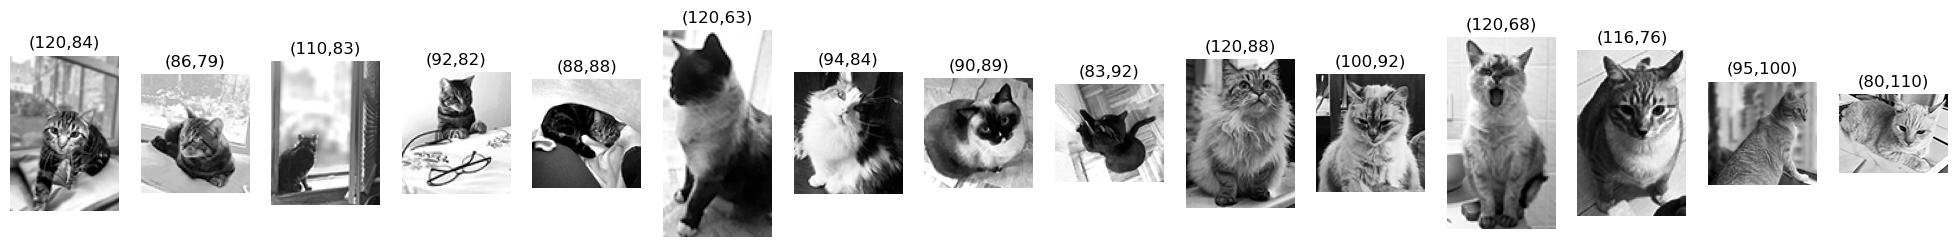

In [8]:
# Clean images: title is M × N
plt.figure(figsize=(25,3))

for i in range(NN):
    plt.subplot(1, NN, i+1);                         plt.imshow( img[i], cmap='gray')
    plt.title('({0},{1})'.format(M[i],N[i]));    plt.axis('off');
plt.show()

# Additional setups

We tune some parameters to check on the efficiency of the method:

In [9]:
global λ, h
global Sub_Γℓ, Sub_DΓℓ, η, Dη

In [10]:
clf = NFFTKernelRidge(sigma=1.0, norm = None, setup = 'default')                       # Instiatate the kernel ridge inner functions
def SSIM(img,u, M,N):  return ssim(img, u.reshape(M,N), data_range=u.max()-u.min())    # Quality measure
def SSIMG(img,u, M,N,  NN):                                                            # Composite quality via mean of means and individual ssim
    co = asarray([SSIM(img[i],u[i], M[i],N[i]) for i in range(NN)])
    return co.mean(), np.array(co)

In [11]:
# Invariant parameters
ρ = 5            # Patch radius
ρ̂ = 2*ρ+1        # Patch length
μ = 1e-2         # Scaling

In [12]:
(1./625)**-0.5

25.0

In [13]:
25**-2, 1/5**4, 1./625

(0.0016, 0.0016, 0.0016)

In [14]:
# Kernel spread
h = 1.0/1600
σ = h**-0.5
print(σ)

40.0


## Working range

In [15]:
# Compute bounds
#fᵂ = [255.0, 255*np.sqrt(3)]
fᵂ = [1.0, 255*np.sqrt(3)]
#print( np.around(fᵂ,2))

ε = 1e-7
print(('{0} {1:>11} {2:>8} {3:>9} {4:>16}').format('Bound', 'Threshold', 'σ', 'h', 'ℜ[exp(-h ⋅)]'))
print('–'*52)
σᵁ = max(fᵂ)/np.sqrt(-np.log1p(-ε))
print( ('Upper:  1 - {0:5.0e} {1:10.2e} {2:10.2e}   1 - {3:1.0e}' ).format(ε, σᵁ, σᵁ**-2, 1-np.exp(-((σᵁ)**-1 * max(fᵂ) )**2 )  ))
ε = 1e-7
σᴸ = min(fᵂ)/np.sqrt(-np.log(ε))
print( 'Lower:   {0:6.0e} {1:10.2f}  {2:11.2e} {3:11.2e}'.format(ε, σᴸ, σᴸ**-2, np.exp(-((σᴸ)**-1 * min(fᵂ) )**2 )  ))

Bound   Threshold        σ         h     ℜ[exp(-h ⋅)]
––––––––––––––––––––––––––––––––––––––––––––––––––––
Upper:  1 - 1e-07   1.40e+06   5.13e-13   1 - 1e-07
Lower:    1e-07       0.25     1.61e+01    1.00e-07


This suggests the working range $h \in [10^{-10}, 15]$.

## Noisy samples

<div class="alert alert-block alert-info">
Now we create a noisy set with noisy images stored in list noisy.
</div>

In [16]:
'''Check if there is a sister dataset with noisy samples'''
folder_Noisy = Path(folder).parent.as_posix() + '/Training_Noisy/'
if not Path(folder_Noisy).exists():
    # If it doesn't exist, create sample
    
    # Fix seed
    rng = default_rng(10)

    # Additive noise: We select by default the noisiest sample
    σ2    = logspace(1,3,5)
    noisy = asarray([clip(img[i] + rng.normal(0, sqrt(σ2[-1]), img[i].shape), 0.0, 255.0) for i in range(NN)])

    print('\nCreating new sub-dataset with additive noise.')

    # Store data set
    Path(folder_Noisy).mkdir(parents=True, exist_ok=True)            # Create directory if not already available
    Noisy_Names = ['TN_' + '0{}.png'.format(i+1) if i < 9 else 'TN_' + '{}.png'.format(i+1) for i in range(NN)]
    [imwrite(folder_Noisy + Noisy_Names[nn], noisy[nn].astype(np.uint8)) for nn in range(NN)]
    
    print('\nData set is ready.')
else:
    # Load sample
    noisy = imread_collection( folder_Noisy + '/*.png', conserve_memory = False)       # Image read
    noisy = asarray([255 * img_as_float(rescale_intensity(i, out_range='uint8')) for i in noisy], dtype='object')
    
    if noisy.shape[0] != NN:
        print('Error: The number of images read is different than the number of images in the dataset.')
    else:
        print(NN, 'images read.')

15 images read.


In [17]:
f = noisy                           # Alias for ease
Quality = SSIMG(img,f, M,N,  NN)

Display images

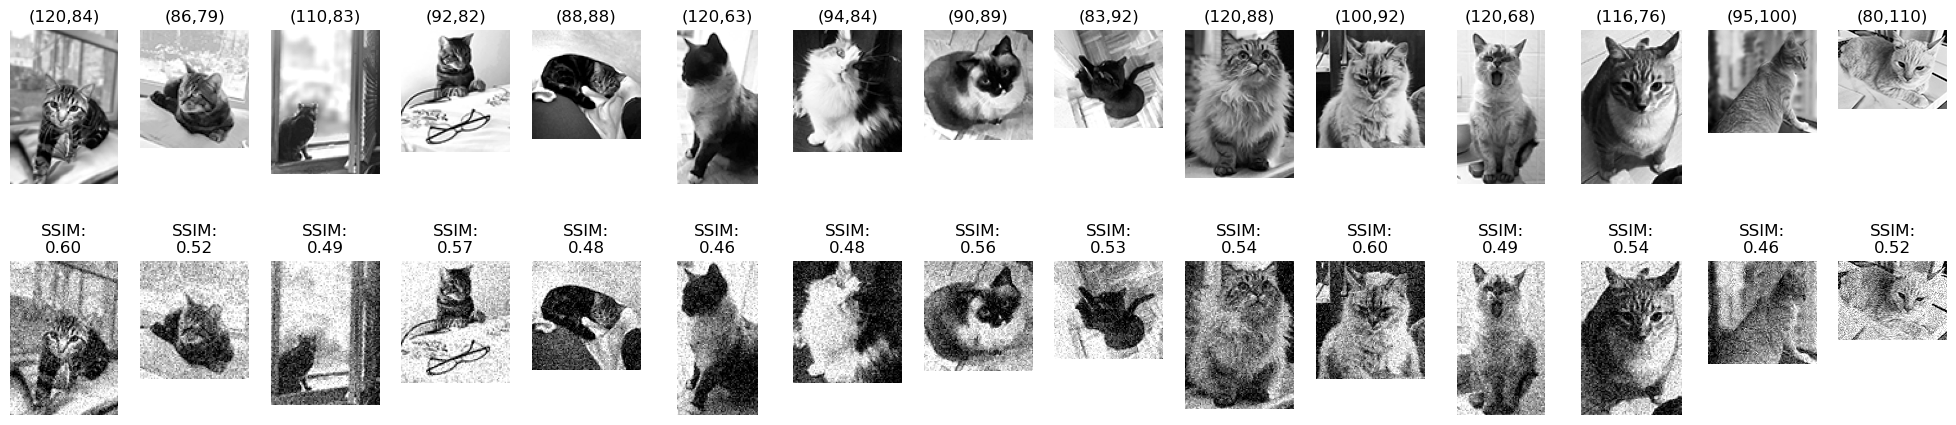

In [18]:
# Clean and noisy images: title is M × N

fig, ax = plt.subplots(2, NN, figsize=(25,5))

for i in range(NN):
    ax[0,i].imshow( img[i], cmap='gray')
    ax[0,i].set_title('({0},{1})'.format(M[i],N[i]));    ax[0,i].axis('off');    ax[0,i].set_anchor('N')
    
    ax[1,i].imshow( noisy[i], cmap='gray')
    ax[1,i].set_title('SSIM:\n{0:.2f}'.format(Quality[1][i]));    ax[1,i].axis('off');    ax[1,i].set_anchor('N')
    
fig.subplots_adjust(hspace=0.5)
plt.show()

If there's already a reconstruction stored locally, then we can compare results with the following code:

In [19]:
folder_Recovered = Path(folder).parent.as_posix() + '/Training_Recovered/'
if Path(folder_Recovered).exists():
    print('n ', '    Noisy SSIM', '      Recovered ')
    u = imread_collection( folder_Noisy + '/*.png', conserve_memory = False)       # Image read
    u = asarray([255 * img_as_float(rescale_intensity(i, out_range='uint8')) for i in u])
    for nn in range(NN):
        print(nn, around(SSIM(img[nn],noisy[nn],M[nn], N[nn]), 13), around(SSIM(img[nn],u[nn],M[nn],M[nn]),13), sep='   ')

## Nonlocal operator via fast summation

<div class="alert alert-block alert-danger">

For a database that would depend on two parameters, we would have to store the MIS indeces and then create a list of functions ``W[nn]``.
</div>

First we obtain the subkernels; i.e., $\Gamma_{i,\ell}$:

In [20]:
# Stored windows
SWindow = [ [[60, 49, 71], [59, 61, 70], [50, 72, 48], [82, 38, 62], [58, 73, 39], [81, 69, 83], [51, 47, 37], [92, 27, 80], [26, 40, 84], [36, 93, 28],
             [57, 52, 74], [68, 91, 79], [63, 46, 29], [41, 94, 16], [104, 105, 15], [35, 64, 85], [103, 30, 17], [95, 56, 25], [75, 90, 102], [34, 67, 78],
             [18, 45, 116], [4, 6, 24], [53, 115, 96], [86, 14, 42], [114, 19, 31], [5, 89, 66], [7, 101, 54], [55, 76, 65], [43, 13, 23], [44, 106, 107],
             [77, 113, 33], [87, 3, 100], [22, 97, 112], [12, 117, 8], [2, 21, 98], [32, 118, 110], [119, 108, 20], [111, 99, 1], [88, 11, 9], [109, 10, 0],
             [120]],
            [[60, 59, 49], [61, 71, 50], [72, 70, 48], [37, 47, 58], [73, 38, 82], [62, 83, 69], [81, 84, 39], [51, 85, 35], [63, 27, 40], [46, 74, 80], 
             [28, 36, 93], [68, 57, 26], [25, 92, 16], [24, 52, 95], [86, 94, 75], [45, 56, 96], [91, 34, 15], [41, 64, 29], [79, 65, 13], [42, 14, 12], 
             [97, 17, 53], [23, 67, 104], [18, 87, 107], [106, 5, 4], [76, 30, 22], [66, 6, 44], [3, 54, 7], [78, 108, 33], [105, 55, 103], [90, 77, 11], 
             [101, 31, 115], [19, 109, 118], [102, 113, 116], [117, 2, 119], [43, 98, 1], [8, 120, 32], [0, 114, 20], [88, 89, 112], [9, 100, 21], 
             [99, 111, 10], [110]],
            [[60, 71, 61], [49, 59, 50], [82, 72, 70], [38, 48, 62], [93, 81, 83], [39, 73, 94], [104, 92, 27], [58, 37, 115], [69, 51, 63], [28, 16, 52], 
             [40, 84, 103], [5, 80, 26], [105, 47, 74], [68, 114, 64], [91, 57, 95], [116, 36, 17], [75, 41, 29], [15, 79, 65], [85, 102, 67], [90, 113, 53],
             [106, 6, 107], [46, 96, 56], [117, 78, 18], [97, 30, 42], [86, 101, 45], [25, 89, 66], [55, 19, 4], [112, 54, 35], [76, 118, 77], [7, 100, 20], 
             [108, 87, 31], [111, 14, 13], [43, 88, 109], [24, 119, 8], [120, 34, 98], [44, 32, 99], [3, 110, 33], [9, 23, 2], [21, 12, 10], [22, 1, 0], 
             [11]],
            [[60, 59, 61], [49, 71, 50], [70, 58, 51], [62, 69, 48], [72, 68, 81], [47, 40, 80], [39, 52, 57], [63, 73, 41], [79, 38, 78], [82, 27, 46], 
             [53, 67, 56], [37, 83, 26], [29, 105, 90], [93, 92, 77], [84, 42, 28], [43, 116, 30], [74, 94, 36], [35, 91, 55], [64, 45, 17], [66, 106, 88], 
             [75, 95, 65], [15, 103, 101], [89, 102, 7], [44, 115, 54], [114, 113, 19], [18, 24, 104], [34, 14, 112], [85, 20, 3], [25, 16, 100], 
             [32, 31, 13], [4, 110, 5], [96, 107, 6], [117, 86, 12], [2, 33, 111], [118, 23, 11], [8, 109, 10], [76, 97, 87], [21, 99, 22], [1, 98, 9], 
             [0, 108, 120], [119]],
            [[60, 59, 61], [71, 49, 72], [70, 48, 50], [82, 73, 58], [83, 81, 62], [37, 38, 69], [47, 39, 84], [74, 57, 36], [63, 93, 51], [94, 46, 85], 
             [95, 80, 68], [35, 26, 92], [27, 104, 52], [40, 91, 105], [86, 96, 75], [28, 25, 56], [103, 106, 67], [41, 16, 79], [64, 34, 97], 
             [15, 45, 102], [29, 17, 87], [90, 53, 24], [115, 76, 65], [116, 114, 23], [107, 55, 78], [14, 117, 108], [33, 18, 109], [42, 13, 101], 
             [118, 54, 119], [5, 44, 30], [98, 6, 113], [66, 12, 89], [4, 77, 120], [19, 31, 3], [2, 22, 11], [100, 112, 43], [1, 7, 111], [88, 20, 9], 
             [32, 8, 99], [0, 21, 110], [10]],
            [[60, 71, 49], [61, 59, 72], [50, 48, 70], [38, 82, 81], [83, 39, 62], [37, 93, 58], [27, 47, 73], [94, 69, 51], [28, 92, 84], [104, 26, 36], 
             [40, 16, 63], [80, 105, 115], [95, 17, 15], [29, 103, 25], [74, 85, 46], [116, 35, 5], [57, 52, 91], [106, 18, 68], [114, 96, 14], [102, 41, 6], 
             [79, 4, 24], [75, 117, 86], [45, 30, 53], [64, 7, 34], [113, 107, 118], [90, 3, 13], [56, 19, 42], [2, 97, 67], [23, 108, 31], [101, 8, 12], 
             [76, 119, 78], [1, 33, 55], [87, 44, 112], [65, 20, 22], [89, 54, 66], [43, 0, 11], [98, 109, 100], [32, 77, 120], [9, 21, 111], [88, 10, 99], 
             [110]],
            [[60, 49, 71], [61, 59, 50], [70, 72, 48], [38, 51, 82], [37, 39, 81], [83, 62, 40], [73, 28, 58], [93, 69, 47], [26, 27, 29], [52, 94, 84], 
             [36, 63, 80], [92, 41, 30], [57, 18, 91], [74, 16, 17], [15, 68, 42], [46, 104, 31], [19, 64, 95], [53, 25, 103], [105, 6, 102], [8, 85, 7], 
             [14, 79, 43], [67, 5, 90], [20, 106, 75], [96, 35, 24], [32, 56, 115], [78, 86, 4], [9, 113, 101], [114, 76, 54], [45, 10, 3], [65, 21, 89], 
             [13, 97, 116], [34, 107, 117], [44, 23, 77], [55, 100, 112], [66, 87, 2], [118, 111, 88], [33, 12, 99], [108, 22, 98], [110, 1, 119], 
             [109, 11, 0], [120]],
            [[60, 61, 71], [59, 49, 50], [70, 72, 48], [58, 38, 39], [82, 62, 51], [73, 37, 69], [81, 83, 47], [40, 80, 63], [27, 57, 36], [52, 84, 46], 
             [74, 26, 68], [28, 94, 41], [25, 92, 93], [29, 64, 53], [91, 85, 79], [42, 95, 35], [56, 75, 45], [67, 17, 16], [90, 15, 18], [96, 103, 78], 
             [24, 102, 104], [55, 30, 54], [65, 34, 86], [106, 31, 66], [44, 43, 19], [105, 14, 107], [89, 76, 77], [20, 6, 23], [114, 101, 5], [7, 33, 13], 
             [97, 87, 4], [115, 117, 112], [32, 100, 12], [88, 21, 108], [2, 22, 99], [8, 3, 116], [113, 118, 11], [98, 110, 0], [1, 111, 119], [109, 10, 9],
             [120]],
            [[60, 49, 59], [71, 61, 48], [50, 72, 70], [82, 62, 37], [38, 83, 58], [69, 51, 39], [81, 73, 47], [80, 40, 36], [84, 94, 26], [93, 28, 27], 
             [57, 68, 63], [52, 16, 79], [25, 92, 95], [46, 105, 85], [15, 106, 67], [35, 56, 29], [41, 14, 74], [104, 91, 78], [17, 103, 90], [5, 96, 53], 
             [4, 116, 30], [42, 102, 13], [3, 66, 24], [45, 117, 77], [115, 89, 64], [75, 18, 55], [107, 86, 54], [31, 6, 118], [44, 101, 34], [43, 113, 2], 
             [20, 65, 7], [114, 88, 19], [100, 33, 76], [99, 12, 8], [23, 21, 1], [108, 87, 32], [97, 109, 112], [119, 111, 11], [9, 98, 22], [120, 0, 110], 
             [10]],
            [[60, 61, 59], [49, 71, 50], [48, 72, 70], [62, 38, 58], [82, 51, 69], [83, 37, 39], [81, 47, 73], [63, 36, 57], [84, 74, 40], [52, 46, 27], 
             [28, 80, 93], [68, 26, 94], [92, 29, 35], [41, 25, 16], [85, 64, 105], [15, 91, 17], [103, 79, 30], [18, 56, 104], [75, 95, 53], [96, 14, 42],
             [106, 5, 24], [67, 115, 102], [6, 116, 45], [78, 90, 4], [114, 7, 54], [107, 113, 86], [34, 8, 13], [19, 43, 65], [89, 23, 31], [101, 55, 76], 
             [9, 44, 77], [118, 20, 97], [32, 108, 3], [21, 66, 33], [117, 98, 12], [87, 112, 2], [99, 10, 22], [109, 119, 1], [111, 100, 88], [120, 11, 0], 
             [110]],
            [[60, 49, 71], [59, 61, 50], [70, 48, 38], [72, 82, 39], [27, 37, 58], [62, 51, 81], [47, 28, 26], [83, 73, 16], [69, 93, 40], [36, 17, 29], 
             [15, 94, 5], [80, 63, 92], [25, 84, 6], [18, 57, 41], [30, 52, 103], [46, 4, 19], [91, 68, 105], [24, 104, 7], [35, 14, 102], [3, 74, 95], 
             [53, 85, 42], [64, 114, 75], [115, 79, 116], [8, 31, 13], [106, 45, 9], [56, 20, 2], [67, 90, 34], [96, 65, 54], [21, 78, 101], [107, 32, 113], 
             [43, 117, 86], [89, 12, 23], [22, 55, 1], [112, 33, 97], [44, 76, 118], [10, 100, 87], [0, 66, 108], [98, 119, 11], [88, 77, 111], 
             [99, 110, 120], [109]],
            [[60, 71, 49], [59, 61, 50], [72, 48, 70], [82, 38, 39], [37, 81, 27], [93, 83, 62], [69, 51, 58], [47, 80, 28], [36, 26, 92], [40, 94, 84], 
             [73, 29, 91], [15, 25, 17], [63, 103, 18], [104, 4, 57], [35, 16, 14], [105, 6, 68], [79, 95, 41], [30, 46, 114], [5, 52, 116], [74, 102, 115], 
             [90, 7, 85], [3, 19, 13], [101, 24, 106], [42, 8, 53], [64, 96, 2], [86, 56, 78], [75, 34, 67], [23, 112, 107], [117, 12, 20], [113, 31, 45], 
             [118, 100, 9], [43, 89, 1], [32, 44, 108], [11, 54, 55], [65, 111, 22], [76, 97, 33], [0, 77, 66], [119, 98, 87], [120, 21, 88], [10, 99, 109], 
             [110]],
            [[60, 71, 49], [59, 61, 50], [70, 82, 72], [48, 81, 38], [39, 69, 51], [58, 80, 62], [92, 83, 93], [40, 47, 91], [28, 63, 52], [79, 41, 73], 
             [27, 37, 57], [68, 29, 90], [30, 74, 18], [78, 17, 102], [42, 94, 53], [104, 84, 19], [46, 64, 103], [31, 101, 26], [16, 56, 89], [67, 75, 95], 
             [20, 36, 6], [45, 114, 85], [9, 112, 100], [65, 113, 8], [111, 25, 32], [54, 105, 7], [115, 77, 43], [88, 21, 66], [15, 35, 55], [99, 86, 5], 
             [96, 10, 110], [76, 116, 4], [24, 106, 44], [97, 34, 87], [14, 13, 33], [3, 107, 117], [23, 98, 108], [12, 118, 22], [109, 2, 119], [120, 11, 1],
             [0]],
            [[60, 59, 71], [49, 61, 48], [72, 82, 70], [50, 58, 81], [38, 93, 39], [47, 37, 92], [27, 69, 62], [83, 80, 73], [94, 26, 57], [28, 68, 104], 
             [84, 16, 115], [36, 51, 40], [91, 105, 15], [46, 103, 5], [114, 35, 29], [67, 52, 102], [63, 79, 25], [6, 17, 56], [90, 18, 41], [116, 74, 4], 
             [34, 106, 95], [14, 24, 113], [45, 85, 3], [117, 55, 23], [7, 77, 101], [53, 110, 64], [30, 66, 111], [44, 112, 86], [78, 96, 19], 
             [100, 88, 107], [13, 97, 89], [31, 33, 2], [75, 99, 118], [20, 12, 8], [9, 42, 11], [22, 43, 32], [0, 108, 87], [76, 65, 54], [98, 109, 21], 
             [1, 119, 120], [10]],
            [[60, 49, 61], [59, 71, 50], [48, 72, 70], [38, 39, 62], [81, 47, 82], [73, 40, 58], [51, 83, 37], [80, 74, 27], [63, 93, 69], [46, 36, 28], 
             [84, 68, 103], [29, 41, 30], [26, 92, 52], [57, 94, 102], [85, 75, 53], [79, 64, 91], [101, 17, 95], [115, 104, 16], [19, 113, 25], [90, 35, 67],
             [86, 42, 100], [31, 56, 87], [106, 45, 78], [89, 108, 98], [6, 14, 111], [88, 112, 114], [15, 116, 18], [107, 4, 76], [96, 109, 65], 
             [66, 55, 24], [110, 44, 5], [54, 43, 34], [21, 99, 118], [7, 77, 8], [11, 20, 105], [32, 117, 97], [12, 13, 119], [3, 22, 10], [33, 9, 2], 
             [23, 120, 1], [0]]
          ]

In [21]:
num_windows = np.empty(NN, dtype=int)
all_Windows = []
k_weight    = np.empty(NN)
Sub_Γℓ = []
Sub_DΓℓ = []

print('{0:^4}|{1:^5}|{2:^5}|{3:^7}|{4:^8}|{5:^6}|{6:^14}|{7:^8}|'.format( 'id', 'Mᵢ', 'Nᵢ', 'Mᵢ×Nᵢ', 'Γℓ[GB]', 'SSIM', 'Windows','Setup' ))
print('–'*65)
for nn in range(NN):
    nm  = M[nn] * N[nn]
    ram_size = np.float64(1).itemsize * np.prod([nm,nm]) / (1024 ** 3)
    print('{0:^4}|{1:^5d}|{2:^5d}|{3:^7d}|{4:^8.2f}|{5:^6.2f}|'.format(nn, M[nn], N[nn], nm, ram_size, Quality[1][nn] ), end = '')
    
    '''
        Kernel Setup
    '''
    Fᵖᵃᵈ = pad(f[nn], ρ, mode='constant')
    X = sliding_window_view(Fᵖᵃᵈ, (ρ̂,ρ̂)).reshape(nm, ρ̂**2)
    
    '''Build windows'''
    start = time.time()
    # determine windows of features by their mis
    if 'SWindow' in globals():
        windows = SWindow[nn]
    else:
        res_idx = clf.make_mi_scores(X, around(f[nn]).astype(int).ravel())
        windows = clf.get_mis_windows(res_idx)
    
    # Measure and store
    all_Windows.append(windows)
    num_windows[nn] = len(windows)
    end = time.time()
    print(' {0:^2d} ({1:5.2f} s) |'.format( num_windows[nn], 0+ end-start ), end = '')
    
    '''Weights'''
    # Compute kernel weights: equal weights that sup up to 1 or no weighting:
    k_weight[nn] = 1.0/num_windows[nn]
    
    '''Kernel as abstract object'''
    def W(σ, n = 64, m = 8, p = 8, Other_Setup = None):
        '''
        Set up the subkernel matrices that constitute the extended Gaussian ANOVA kernel

        Note
        ----
        Using the NFFT-approach, the kernel matrices are never computed explicitly.

        Parameters
        ----------
        X : ndarray
            The training data matrix.
        σ : float
            Shape of the kernel.
        n : even int
            The NFFT expansion degree.
        m : int ≤ max(N,M)
            Window cutoff.
        p : int
            Smoothness of the window function.

        Returns
        -------
        SubKernels : list of fastadj.AdjacencyMatrix
            Subkernel matrices for each window of features according to the selected window scheme.
        '''

        # Bound on window cutoff [Lemma 3.4]
        if n < max([4*m,12]):
            print('Changing n = {} to {}'.format(n, max([4*m,12])))
            n = max([4*m,12])

        # Setup approximation parameters
        NFFT_setup = fastadj.AccuracySetup(n,m,p,0,0)   if Other_Setup is None else   Other_Setup

        # Set diagonal → 0, since FastAdjacency package is targeted at graph Laplacian with zeros at the diagonal
        #return [fastadj.AdjacencyMatrix(X[:,windows[l]], σ, NFFT_setup, 0.0) for l in range(num_windows[nn])]
        return [f_A2.AdjacencyMatrix(X[:,windows[l]], σ, kernel = 1, setup = NFFT_setup, diagonal = 0.0) for l in range(num_windows[nn])]
    
    '''Unsigned derivative of kernel'''
    def DW(σ, n = 64, m = 8, p = 8, Other_Setup = None):
        '''
        Set up the subkernel matrices that constitute the derivative of the extended Gaussian ANOVA kernel with respect to h by using σ as a proxy

        Returns
        -------
        SubKernels : list of fastadj.AdjacencyMatrix
            Subkernel matrices for each window of features according to the selected window scheme.
        '''

        # Bound on window cutoff [Lemma 3.4]
        if n < max([4*m,12]):
            print('Changing n = {} to {}'.format(n, max([4*m,12])))
            n = max([4*m,12])

        # Setup approximation parameters
        NFFT_setup = fastadj.AccuracySetup(n,m,p,0,0)   if Other_Setup is None else   Other_Setup

        # Set diagonal → 0, since FastAdjacency package is targeted at graph Laplacian with zeros at the diagonal
        return [f_A2.AdjacencyMatrix(X[:,windows[l]], σ, kernel = 2, setup = NFFT_setup, diagonal = 0.0) for l in range(num_windows[nn])]
    
    
    start = time.time()
    Sub_Γℓ.append( W(σ, Other_Setup = 'default') );    Sub_DΓℓ.append( DW(σ, Other_Setup = 'default') )
    end = time.time()
    print('{0:5.2f} s'.format( end - start ))
    
    print('–'*65)

 id | Mᵢ  | Nᵢ  | Mᵢ×Nᵢ | Γℓ[GB] | SSIM |   Windows    | Setup  |
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 0  | 120 | 84  | 10080 |  0.76  | 0.60 | 41 ( 0.00 s) | 0.67 s
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 1  | 86  | 79  | 6794  |  0.34  | 0.52 | 41 ( 0.00 s) | 0.42 s
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 2  | 110 | 83  | 9130  |  0.62  | 0.49 | 41 ( 0.00 s) | 0.52 s
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 3  | 92  | 82  | 7544  |  0.42  | 0.57 | 41 ( 0.00 s) | 0.46 s
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 4  | 88  | 88  | 7744  |  0.45  | 0.48 | 41 ( 0.00 s) | 0.44 s
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 5  | 120 | 63  | 7560  |  0.43  | 0.46 | 41 ( 0.00 s) | 0.43 s
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 6  | 94  | 84  | 7896  |  0.46  | 0.48 | 41 ( 0.00 s) | 0.45 s
––––––––––––––––––––––––

Now let's assemble the operators for all the subkernels:

In [22]:
def AK_n(nn):
    def AK(u):
        """
        Approximate the matrix-vector product AK*u, where AK = w * (K_1 + K_2 + ... + K_L).

        Note
        ----
        Since this function serves a LinearOperator from scipy, only one variable can be passed as input parameter.
        Any other variable needed has to be global, so that they can still be used within this function

        Parameters
        ----------
        u : ndarray
            The vector, whose product AK*u with the matrix AK shall be approximated.

        Returns
        -------
        AKu : ndarray
            The approximated matrix-vector product AK*u.
        """
        # Apply matrix-vector multiplication
        AKu = np.zeros_like(u)
        for l in range(num_windows[nn]):
            AKu += Sub_Γℓ[nn][l].apply(u)
        # Multiply each subKernel by its weight and collect into a sum
        AKu *= k_weight[nn]
        return AKu
    return AK

In [23]:
AKs = [AK_n(nn) for nn in range(NN)]

In [24]:
start = time.time()
η = asarray([AKs[nn]( ones(M[nn] * N[nn]) ) for nn in range(NN)], dtype='object')
end = time.time()
print('Sequential application: {0:.2f} s'.format( end - start ))

Sequential application: 18.06 s


---

We can improve this with a parallel implementation instead. We can take two paths here that define how our code works. (1) We can parallelise the action of all kernels; i.e., the list of functions that represent each kernel against the list of inputs representing each image, or (2) we can instead serialise the action of all kernels but parallelise the action of each subkernel. The former method allows us to build a block system, while the latter solves systems sequentially. The former method was implemented in a previous version alongside a multi block version of the dense preconditioners. However, we noticed that the number of CG iterations was increasing, maybe due to the relative norm criterion preventing CG to stop. As a result, if the problem was well conditioned and, say, five iterations were enough per image, it was observed that instead this number was multiplied by the total number of images. Hence, parallelising wasn't as effective.

In this version of the code we implement strategy (2).

In [25]:
nm   = np.prod([M,N],0).sum()                  # Total problem size
nm_s = np.prod([M,N],0)                        # Particular sizes
cuts = np.r_[0,np.cumsum(np.prod([M,N],0))]    # Indices to identify each subblock
# Check with [np.count_nonzero(np.concatenate(η)[ cuts[nn]:cuts[nn+1] ] - η[nn]) for nn in range(NN)]

In [26]:
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp                                                                                     
#mp.set_start_method("fork")
mp_fork = mp.get_context('fork')

In [27]:
Ones = [ones(M[nn] * N[nn]) for nn in range(NN)]

In [28]:
# Function to be executed in parallel
def compute_vector(nn, l, u):
    """Apply the function Sub_Γℓ[nn][l] to u[nn]"""
    #return funs[nn][l](u)
    return Sub_Γℓ[nn][l].apply(u)

In [29]:
def AK_n(nn):
    # Outer function selects the index nn and prepares the evaluator
    results = empty([num_windows[nn], nm_s[nn]])        # Initialize a structure to hold the results
    def AK(u):
        nonlocal nn  # Declare that nn is not a local variable
        """
        Approximate the matrix-vector product AK*u, where AK = w * (K_1 + K_2 + ... + K_L).

        Note
        ----
        Since this function serves a LinearOperator from scipy, only one variable can be passed as input parameter.
        Any other variable needed has to be global, so that they can still be used within this function

        Parameters
        ----------
        u : ndarray
            The vector, whose product AK*u with the matrix AK shall be approximated.

        Returns
        -------
        AKu : ndarray
            The approximated matrix-vector product AK*u.
        """
        
        # Apply matrix-vector multiplication in parallel
        with ProcessPoolExecutor(max_workers=8, mp_context=mp_fork) as executor:
            # Create all possible (nn, l) pairs and execute them in parallel
            futures = {executor.submit(compute_vector, nn, l, u): (nn, l) for l in range(num_windows[nn])}

            # Collect the results as they complete
            for future in concurrent.futures.as_completed(futures):
                nn, l = futures[future]
                try:
                    results[l] = future.result()
                except Exception as e:
                    print(f"An error occurred at (nn={nn}, l={l}): {e}")
        
        # Add up products and weight
        AKu = results.sum(0) * k_weight[nn]
        
        return AKu
    return AK

In [30]:
AKs = [AK_n(nn) for nn in range(NN)]

In [31]:
start = time.time()
ηᴾ = asarray([AKs[nn](Ones[nn]) for nn in range(NN)], dtype='object')
end = time.time()
print('Parallel application - 8: {0:.2f} s'.format( end - start ))

Parallel application - 8: 5.30 s


In [32]:
# Store Dη
start = time.time()
Sub_Γℓ, Sub_DΓℓ = Sub_DΓℓ, Sub_Γℓ
Dη = asarray([AKs[nn](Ones[nn]) for nn in range(NN)], dtype='object')
Sub_Γℓ, Sub_DΓℓ = Sub_DΓℓ, Sub_Γℓ
end = time.time()
print('Parallel application - 8: {0:.2f} s'.format( end - start ))

Parallel application - 8: 8.19 s


In [33]:
[np.count_nonzero((ηᴾ - η)[nn]) for nn in range(NN)]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

We might need to modify this function a little for receiving vectorial inputs so that we can use CG with ease.

---

Each kernel will be ill-conditioned whenever $\lambda < 10^{-1}$:

In [34]:
print('–'*80)
for nn in range(NN):
    print('id: {0:2d} – '.format(nn), end = '')
    nm  = M[nn] * N[nn]
    ram_size = np.float64(1).itemsize * np.prod([nm,nm]) / (1024 ** 3)
    print( '(Γℓ)_ℓ: {0:6.2f} [GB] – '.format(ram_size * num_windows[nn]), end = '' )
    # Approximate numerical range
    E_A = μ * η[nn].max()
    e_A = μ * η[nn].min() * nm/(nm-1)
    print('Ŵᶠᵃˢᵗ(B) - {0}:' +  7*' ' + '{0:5.2f}  {1:8.2e}'.format( E_A, e_A ) )
    print('–'*80)

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  0 – (Γℓ)_ℓ:  31.04 [GB] – Ŵᶠᵃˢᵗ(B) - {0}:        5.66  1.34e+00
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  1 – (Γℓ)_ℓ:  14.10 [GB] – Ŵᶠᵃˢᵗ(B) - {0}:        5.53  8.11e-01
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  2 – (Γℓ)_ℓ:  25.46 [GB] – Ŵᶠᵃˢᵗ(B) - {0}:        9.56  1.24e+00
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  3 – (Γℓ)_ℓ:  17.39 [GB] – Ŵᶠᵃˢᵗ(B) - {0}:       13.71  5.33e-01
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  4 – (Γℓ)_ℓ:  18.32 [GB] – Ŵᶠᵃˢᵗ(B) - {0}:        6.26  9.10e-01
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  5 – (Γℓ)_ℓ:  17.46 [GB] – Ŵᶠᵃˢᵗ(B) - {0}:        7.80  9.90e-01
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  6 – (Γℓ)_ℓ:  1

Largest smallest estimation of the algebraic connectivity:

In [35]:
max([μ * η[nn].min() * nm_s[nn]/(nm_s[nn]-1) for nn in range(NN)])

1.3363293350327254

This is the total memory consumption that would take to have all subkernels in matrix form:

In [36]:
ram_sizes = [np.float64(1).itemsize * ( (M[nn] * N[nn])**2 ) / (1024 ** 3) * num_windows[0] for nn in range(NN)]
print('{0:.0f} [GB]'.format(sum(ram_sizes)))

335 [GB]


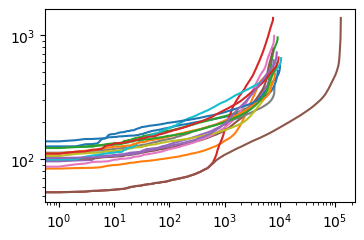

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(4,2.5))
for nn in range(NN):
    plt.plot(np.sort(η[nn]))

plt.plot( np.sort(np.concatenate(η)) )
plt.yscale('log'); plt.xscale('log')

## List of functions

Let us assemble a list of operators that will allow us to compute $A_i u_i$ with $u_i \in u$ for any index at will. This will require multiple runs of CG but of a smaller dimension than the full combined problem.

In [38]:
global λ
λ = 1.0    # Just for initialisation

In [39]:
def MatVecs(nn):
    # Define matrix vector multiplications for a choice of nn
    def matvec(v):
        nonlocal nn
        return μ * (η[nn] * v - AKs[nn](v)) + λ * v
    return matvec

In [40]:
A = [LinearOperator((nm_s[nn],nm_s[nn]), dtype=np.float64, matvec=MatVecs(nn), rmatvec=MatVecs(nn)) for nn in range(NN)]

In [41]:
uT = asarray([i.flatten() for i in img], dtype='object')    # Flatten clean images
ff = asarray([i.flatten() for i in f], dtype='object')      # Flatten noisy samples

In [42]:
A[nn](Ones[nn])

array([1., 1., 1., ..., 1., 1., 1.])

## Change of basis

We need to apply the change of basis for each subdimension.

In [43]:
from operator import setitem

In [44]:
# Basis change only depends on the dimension of each image, so we only have to define it once
not_e_1 = [ones(nm_s[nn]) for nn in range(NN)]
[setitem(not_e_1[nn], 0 , 0.0) for nn in range(NN)];

aux_h = [np.arange(nm_s[nn]) for nn in range(NN)]
aux_d = [np.reciprocal(np.sqrt( np.concatenate( ([nm_s[nn]], np.arange(2,nm_s[nn]+1) * np.arange(1,nm_s[nn]) ) ) ))  for nn in range(NN)]

In [45]:
def MV_basis_U_T(v, nn):
    '''
        Transpose of unitary transformation
    '''
    v = v if isinstance(v, np.ndarray) else asarray(v)    # Ensure an ndim array is given
            
    # We iteratively apply U.T to each slice
    U_T_v = aux_d[nn] * (np.roll( np.cumsum(v),1) - (aux_h[nn] * v))
    
    return asarray(U_T_v)

In [46]:
def MV_basis_U(v, nn):
    '''
        Unitary transformation
    '''
    v = v if isinstance(v, np.ndarray) else asarray(v)    # Ensure an ndim array is given
        
    # We iteratively apply U to each slice
    w   = aux_d[nn] * v
    U_v = ((w.sum() - np.cumsum(w)) * np.flip(not_e_1[nn])) - (aux_h[nn] * w) + w[0]
    
    return asarray(U_v)

In [47]:
all([allclose(MV_basis_U_T( MV_basis_U(Ones[nn],nn), nn), 1) for nn in range(NN)])

True

In [48]:
# Projections
Prec_RHS = asarray([MV_basis_U_T(ff[nn],nn) for nn in range(NN)], dtype='object')

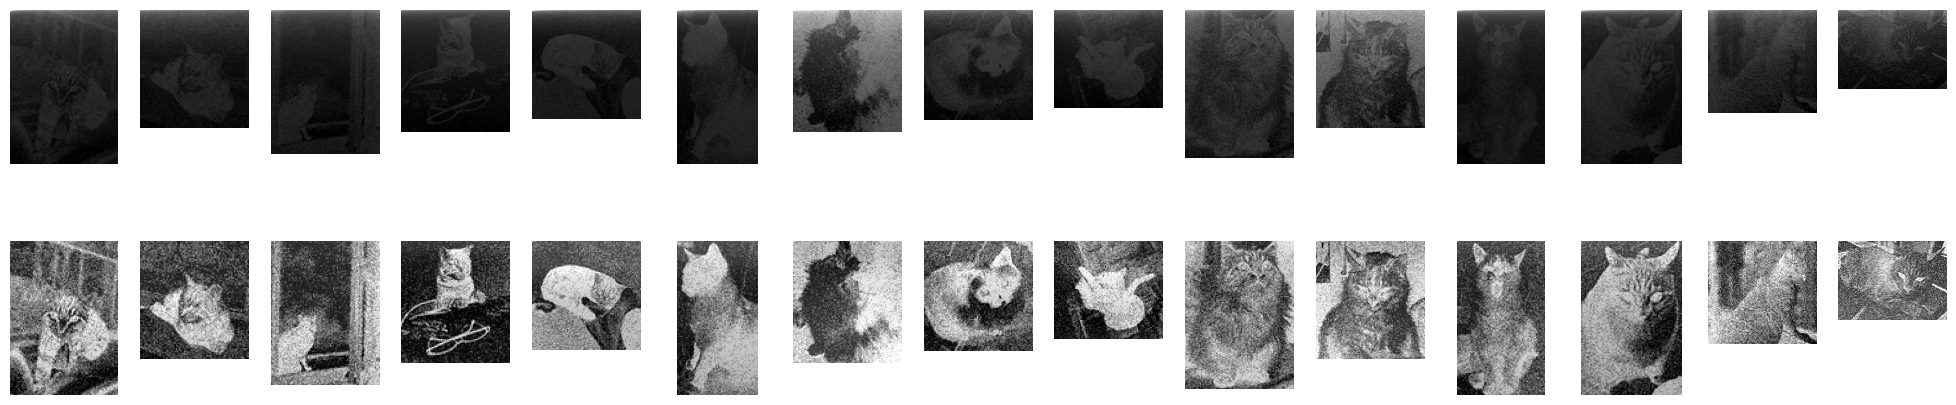

In [49]:
# Noisy images under new base
U_ff = [MV_basis_U(ff[nn],nn) for nn in range(NN)];      U_T_ff = [MV_basis_U_T(ff[nn],nn) for nn in range(NN)]
[setitem(U_T_ff[nn], 0 , 100.0) for nn in range(NN)];    # First entry has largest intensity, so we clip it
U_ff = [U_ff[i].reshape(M[i],N[i]) for i in range(NN)];    U_T_ff = [U_T_ff[i].reshape(M[i],N[i]) for i in range(NN)]

fig, ax = plt.subplots(2, NN, figsize=(25,5))

for i in range(NN):
    ax[0,i].imshow(   U_ff[i], cmap='gray');    ax[0,i].axis('off');    ax[0,i].set_anchor('N')
    ax[1,i].imshow( U_T_ff[i], cmap='gray');    ax[1,i].axis('off');    ax[1,i].set_anchor('N')
    
fig.subplots_adjust(hspace=0.5)
plt.show()

<div class="alert alert-block alert-warning">
<b>Subblocks</b>
</div>

We define a list of operators where each works on its corresponding $n_i-1$ subblock after the change of basis. For this, we need to have the backward operator which will project back each subvector into a $n_i$ dimensional space.

In [50]:
# Define subblock of system
def MAM_op(nn):
    # Define matrix vector multiplications for a choice of nn
    def MV_basis_MAM(v):
        nonlocal nn
        '''
            Project back v, change basis by U, apply A, then U.T, and project; i.e., (P U.T A U) P.T v
        '''
        w = np.concatenate( ([0.0], v) )
        w = MV_basis_U_T( A[nn].dot( MV_basis_U( w, nn ) ), nn )
        return w[1:]

    return MV_basis_MAM

In [51]:
MAM = [LinearOperator((nm_s[nn]-1,nm_s[nn]-1), dtype=np.float64, matvec=MAM_op(nn), rmatvec=MAM_op(nn)) for nn in range(NN)]

In [52]:
Vs = zeros(nm_s[nn]);    Vs[0] = 1.0
allclose(MV_basis_U_T(  A[nn].dot(MV_basis_U( Vs, nn )), nn), λ*Vs)

True

We define an operator that works into each $n_i-1$ subblock after the change of basis. For this, we need to have the backward operator which will project back each subvector into a $n_i$ dimensional space.

In [53]:
nm   = np.prod([M,N],0).sum()

In [54]:
# Create a boolean mask for where to place the original values
w_mask = np.ones(nm, dtype=bool);    w_mask[cuts[:-1]] = False    # Zeros are located at cutoffs

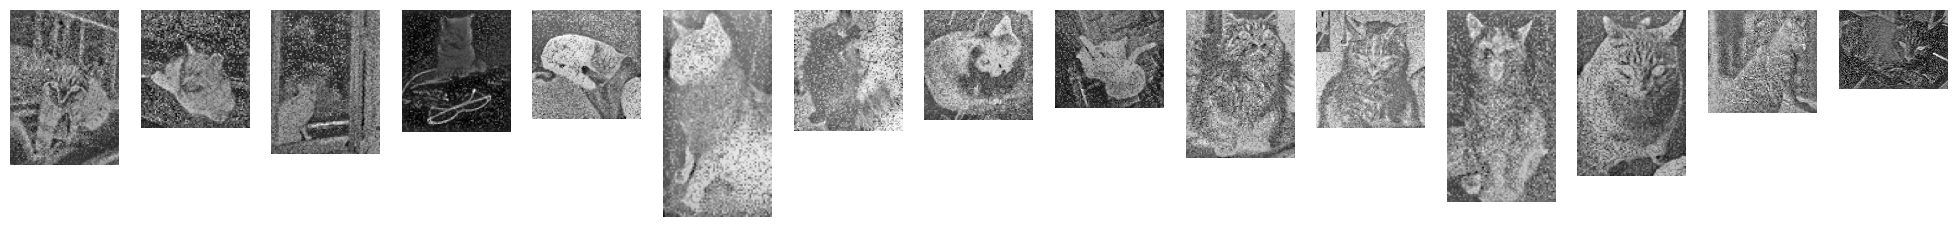

In [55]:
# Application of subblock but projected back
v_test = np.concatenate([MAM[nn](Prec_RHS[nn][1:]) for nn in range(NN)])
U_ff = np.zeros(nm)        # Initialize the backward projection
U_ff[w_mask] = v_test
U_ff = [U_ff[ cuts[nn]:cuts[nn+1] ].reshape(M[nn],N[nn]) for nn in range(NN)]

fig, ax = plt.subplots(1, NN, figsize=(25,5))

for i in range(NN):
    ax[i].imshow(   U_ff[i], cmap='gray');    ax[i].axis('off');    ax[i].set_anchor('N')
    
fig.subplots_adjust(hspace=0.5)
plt.show()

Similarly, define the preconditioners for each subproblem:

In [56]:
# Define sub preconditioners
def UDU_op(nn):
    # Define matrix vector multiplications for a choice of nn
    def Proj_Prec_Diag(v):
        nonlocal nn
        '''
            Project back v, change basis by U, apply M, then U.T, and project; i.e., (P U.T A U) P.T v
        '''
        w = np.concatenate( ([0.0], v) )
        w = MV_basis_U_T( diag_P[nn] * MV_basis_U(w,nn), nn )
        return w[1:]

    return Proj_Prec_Diag

In [57]:
UDU = [LinearOperator((nm_s[nn]-1,nm_s[nn]-1), dtype=np.float64, matvec=UDU_op(nn), rmatvec=UDU_op(nn)) for nn in range(NN)]

In [58]:
diag_P = η**-1    # Example for test

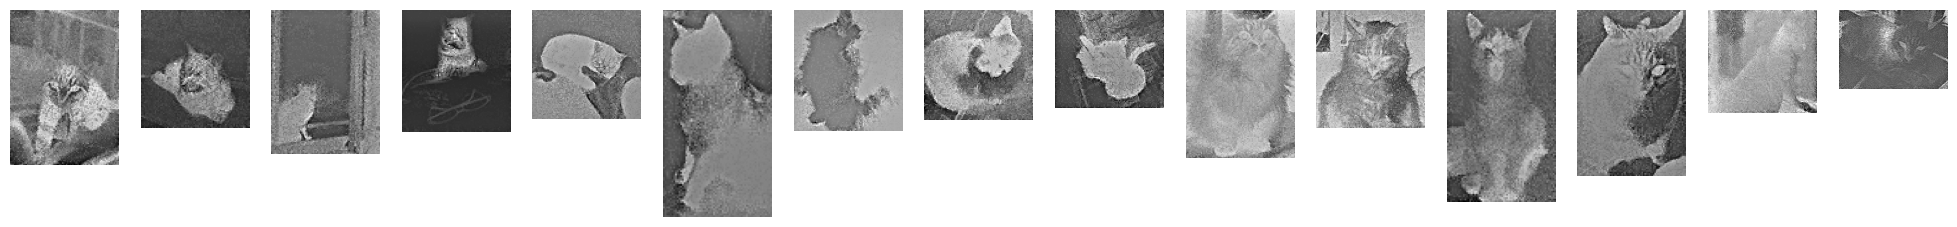

In [59]:
# Application of subblock but projected back
v_test = np.concatenate([UDU[nn](Prec_RHS[nn][1:]) for nn in range(NN)])
U_ff = np.zeros(nm)        # Initialize the backward projection
U_ff[w_mask] = v_test
U_ff = [U_ff[ cuts[nn]:cuts[nn+1] ].reshape(M[nn],N[nn]) for nn in range(NN)]

fig, ax = plt.subplots(1, NN, figsize=(25,5))

for i in range(NN):
    ax[i].imshow(   U_ff[i], cmap='gray');    ax[i].axis('off');    ax[i].set_anchor('N')
    
fig.subplots_adjust(hspace=0.5)
plt.show()

## Bilevel setup

<div class="alert alert-block alert-info">
Numba functions are defined to compute the objective function quickly.
</div>

In [60]:
# Numba functions
@jit(nopython=True, parallel=True)
def ar(x):    return np.around(x,4)
@jit(nopython=True, parallel=True)
def ar0(x):   return np.around(x,0)

In [61]:
@jit(nopython=True, parallel=True)
def Snorm(u):      return norm(u)**2                # Squared norm of a vector
#@jit(nopython=False, parallel=True)
def Objective(u):                                   # Objective value 
    so = 0.0
    for nn in range(NN):
        so += Snorm(u[nn] - uT[nn])
    so /= (2 * NN)
    return so

In [62]:
"""First eval"""
ar(1.2); ar0(1.2); Objective(ff);

<div class="alert alert-block alert-info">
Basics are defined:
    
1. There are no numerical constraints related to $b$, thus we let it free and set $b=10^{10}$.

3. `nm` $=N\times M$, and `P` stores the preconditioner of matrix `A`.

4. Variables $u$ and $p$ indicate the state and adjoint variables, `fx` $=f(\lambda_k)$, `lamb` $=\lambda_k$, `l_u` is the RH side of the system $(\lambda + \Gamma - \gamma) u = \lambda f$, `l_p` is the RH of the system $(\lambda + \Gamma - \gamma) p = u-u^\top$, `u_f` stores the difference $u-f$, `C` stores $\Gamma$, `df` stores the value of the gradient at the actual point, `PA` stores the diagonal preconditioner  information which is updated with the help of `PC`, `sx` stores the best $\mathtt{SSIM}$ values, `us` will store the best solution in the sense of `sx`, and `sl` the matrix weight that got such solution.

4. `ff` and `uT` store the noisy and clean versions of the image. We use the former as a initial point if there's none defined.
</div>

In [63]:
global u, p, l_u, l_p, df, diag_P,   fx, sx, us, sl, f_u

if 'λ' not in globals():    λ = 0.1          # λ is known to be small
if 'u' not in globals():    u = ff.copy()
if 'p' not in globals():    p = ff.copy()

# Reserve memory
l_u = asarray([i.copy() for i in ff], dtype='object');    l_p, f_u = l_u.copy(), l_u.copy()
sx, sl = 0.0, 0.0
df = array([0.0, 0.0])
diag_P = asarray([zeros(nm_s[nn]) for nn in range(NN)], dtype='object')

## Lower level functions

<div class="alert alert-block alert-warning">
<b>Solvers</b>
</div>

To evaluate the objective functional, we solve the state equation
\begin{align*}
    (u_i,\phi)_V + \big( \lambda u_i, \phi \big) = \big( \lambda f_i, \phi \big), & &\forall \phi \in V_i, i\in [0:N-1].
\end{align*}
Then to get the derivative, we solve the adjoint equation
\begin{align*}
    (p_i,\phi)_V + \big( \lambda p_i, \phi \big) = \dfrac{1}{N} (u_i - u_i^\top,\phi), & &\forall \phi \in V_i, i\in [0:N-1].
\end{align*}
Then we can assemble the gradient:
\begin{align*}
    \partial_\lambda f(\lambda, h) = \sum_{i=0}^{N-1}  ( f_i - u_i, p_i )
    \qquad
    \partial_h f(\lambda, h) = \sum_{i=0}^{N-1}  -( u_i, p_i )_{\widetilde{V_i}}
    .
\end{align*}

$\DeclareMathOperator{\AKh}{\mathrm{AK}_h}$
Here we have that:
\begin{align}
    (u,\phi)_{\widetilde{V_i}} = \big( u \, [\partial_h \AKh] \mathbb{1} - [\partial_h \AKh] u, \phi \big)_{L^2(\Omega)}.
\end{align}
In terms of $\AKh$, we have that
\begin{align}
    \partial_h \AKh u (x) = \sum_{\ell=1}^L \frac{1}{\sf L} \int_\Omega -u(y)\, {\big\| \mathcal{W}_\ell [f](x) - \mathcal{W}_\ell [f](y) \big\|^2} e^{-h \big\| \mathcal{W}_\ell [f](x) - \mathcal{W}_\ell [f](y) \big\|^2}  \mathrm{d}y,
\end{align}

To solve the systems, we will use the block-to-decoupled dense preconditioners under $U$. For each $i \in [0:N-1]$, we project the problem to the basis given by $U_{n_i}$, then:
- The sub system $U_{n_i}^\top A_{n_i} U_{n_i} \mathbf{x} = U_{n_i}^\top \mathbf{f} = \mathbf{g}$ features a block-diagonal matrix. 
- We decouple the system, the first block is just $[\lambda]_{1,1} x_1 = g_1 $ with solution $x_1 = \lambda^{-1} g_1$.
- We apply preconditioned CG to the subsystem $\pi_{2,n_i}( U_{n_i}^\top A_{n_i} U_{n_i}) \mathbf{x}_{2:n_i} = \mathbf{g}_{2:n_i}$.
- We then assemble a solution $\mathbf{x}$ with the two blocks.
- Define $\mathbf{u}$ by transforming $\mathbf{x}$ back to the original basis and multiply by $\lambda$; i.e., $\mathbf{u} = \lambda U_{n_i}\mathbf{x}$ (notice that alternatively, we can define $\mathbf{u} = U_{n_i}[g_1, \lambda \mathbf{x}_{2:n_i}]$, which is better considering $\lambda^{-1}$ can suffer from cancelation errors).
- The resulting vector solves $ A_{n_i} \mathbf{u} = \lambda \mathbf{f}$.

In [64]:
# Create a counter that will return how many iterations of each method were performed
global g_cg_it, cg_its
g_cg_it = 0
def solver_call(xk):
    global g_cg_it
    g_cg_it += 1

In [65]:
u = asarray([i.copy() for i in ff], dtype='object')
p = asarray([i.copy() for i in ff], dtype='object')

In [66]:
def obj_eval(x, Force_h = False):                  # ** Eval f and f' ** #
    global u, p, df,   diag_P, l_p,   g_cg_it, cg_its
    global λ, h
    global Sub_Γℓ, Sub_DΓℓ, η, Dη
    
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    # Identify components
    λ, h = x
    σ = h**-0.5
    
    # If h changes, then update kernels and η
    if (abs(Sub_Γℓ[0][0].sigma - σ) > 1e-12) or Force_h:             # All kernels share the same shape
        # Update Γₕ
        deque((ker.__setattr__('sigma', σ)   for nn in range(NN)   for ker in Sub_Γℓ[nn]), 0);
        # Update DΓₕ
        deque((ker.__setattr__('sigma', σ)   for nn in range(NN)   for ker in Sub_DΓℓ[nn]), 0);
        # Update η
        η = asarray([AKs[nn](Ones[nn]) for nn in range(NN)], dtype='object')
        # Store Dη
        Sub_Γℓ, Sub_DΓℓ = Sub_DΓℓ, Sub_Γℓ
        Dη = asarray([AKs[nn](Ones[nn]) for nn in range(NN)], dtype='object')
        Sub_Γℓ, Sub_DΓℓ = Sub_DΓℓ, Sub_Γℓ
        
    
    # Check feasibility for λ
    if λ < 0.0:        return 4*Snorm(u) + 1e+4, asarray([-1e+10, -1e+10])    # In case something goes off, penalise negative values of λ
    
    # Build simple diagonal preconditioner [don't forget about μ]
    add(μ * η, λ, out = diag_P);    reciprocal(diag_P, out = diag_P);
    
    Prec_x_0 = asarray([MV_basis_U_T(u[nn],nn) for nn in range(NN)], dtype='object') / λ     # Project initial solution
    
    # Solve state and adjoint systems
    cg_its = [[],[]]
    for nn in range(NN):
        '''    State u    '''
        ## MAM x = g / s  ->  [sx] solves MAM uₒ = g, in particular we could take s = ‖g‖
        s = norm(Prec_RHS[nn][1:])
        g_cg_it = 0
        uₒ, status = cg(MAM[nn], Prec_RHS[nn][1:]/s, x0 = Prec_x_0[nn][1:]/s, rtol = 1e-10, maxiter = 25, M = UDU[nn], callback = solver_call)
        uₒ *= s
        #print( '{0:.2e} {1:.2e}'.format( norm(MAM[nn](uₒ) - Prec_RHS[nn][1:]), norm(MAM[nn](uₒ) - Prec_RHS[nn][1:])/norm( Prec_RHS[nn][1:] ) ))

        # Build solution out of blocks
        u[nn][1:] = λ * uₒ                   # Second block
        u[nn][0]  = Prec_RHS[nn][0].copy()   # First subblock
        u[nn] = MV_basis_U(u[nn],nn)         # Go back to original basis
    
        cg_its[0].append(g_cg_it)
        
        
        '''    Adjoint p    '''
        subtract(u[nn], uT[nn], out = l_p[nn]);    l_p[nn] /= NN;    subtract(ff[nn], u[nn], out = f_u[nn])
        U_T__l_p = MV_basis_U_T(l_p[nn],nn)         # Define new RHS
        s = norm(U_T__l_p)

        # Solve adjoint system
        g_cg_it = 0
        pₒ, status = cg(MAM[nn], U_T__l_p[1:]/s, x0 = MV_basis_U_T(p[nn],nn)[1:]/s, rtol = 1e-8, maxiter = 20, M = UDU[nn], callback = solver_call)
        pₒ *= s

        # Build solution out of blocks
        p[nn][1:] = pₒ                              # Second block
        p[nn][0]  = (U_T__l_p[0] / λ)               # First subblock
        p[nn] = MV_basis_U(p[nn],nn)                # Go back to original basis
        
        cg_its[1].append(g_cg_it)
        
    # Partial derivative w.r.t. λ
    df_λ = np.sum([(f_u[nn] * p[nn]).sum() for nn in range(NN)])

    # Partial derivative w.r.t. σ:        We switch between kernels to avoid re-defining operators 
    Sub_Γℓ, Sub_DΓℓ = Sub_DΓℓ, Sub_Γℓ
    η, Dη = Dη, η

    df_σ = μ * np.sum([p[nn].dot(A[nn].dot(u[nn]) - λ*u[nn]) for nn in range(NN)])/h

    Sub_Γℓ, Sub_DΓℓ = Sub_DΓℓ, Sub_Γℓ
    η, Dη = Dη, η
        
        
    '''    Derivative    '''
    df = asarray([df_λ, df_σ])
    return array(Objective(u)), df

---

In [67]:
start = time.time()
print(obj_eval([1.0, 7e-4]))
end = time.time()
print('{0:.2f} s'.format(end-start))

(array(6233331.75455381), array([7.79870277e+07, 1.03159344e+09]))
120.51 s


In [68]:
df

array([7.79870277e+07, 1.03159344e+09])

In [69]:
array(Objective(u))

array(6233331.75455381)

In [70]:
cg_its

[[10, 10, 11, 9, 10, 11, 10, 10, 11, 10, 10, 11, 10, 10, 10],
 [9, 9, 9, 8, 9, 9, 8, 9, 9, 8, 8, 9, 9, 9, 8]]

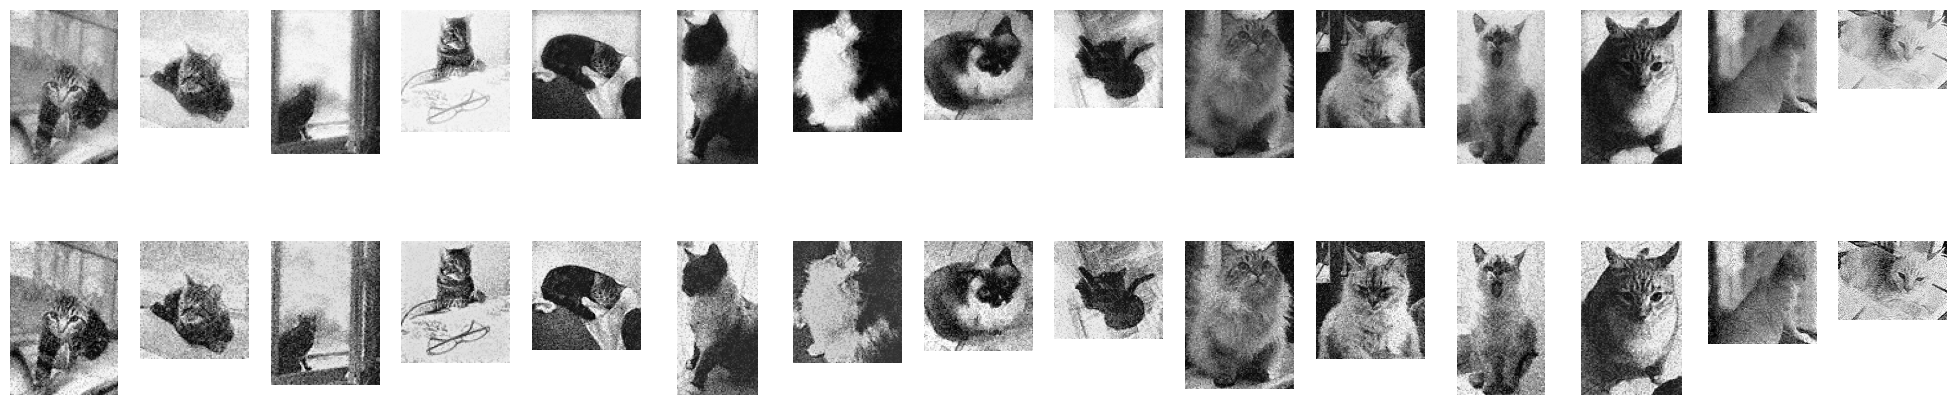

In [71]:
# Application of subblock but projected back
U_ff = [u[nn].reshape(M[nn],N[nn]) for nn in range(NN)]
P_ff = [p[nn].reshape(M[nn],N[nn]) for nn in range(NN)]

fig, ax = plt.subplots(2, NN, figsize=(25,5))

for i in range(NN):
    ax[0,i].imshow(   U_ff[i], cmap='gray');    ax[0,i].axis('off');    ax[0,i].set_anchor('N')
    ax[1,i].imshow(   P_ff[i], cmap='gray');    ax[1,i].axis('off');    ax[1,i].set_anchor('N')
    
fig.subplots_adjust(hspace=0.5)
plt.show()

---

<div class="alert alert-block alert-warning">
<b>Prepare functions for coordinate descent</b>
</div>

In [72]:
def obj_eval_a(x):                  # ** Eval f ** #
    global u,   diag_P,   g_cg_it, cg_its
    global λ, h
    global Sub_Γℓ, η
    
    '''
        Evaluate state and return objective
    '''
    # Identify components
    λ, h = x
    σ = h**-0.5
    
    # If h changes, then update kernels and η
    if abs(Sub_Γℓ[0][0].sigma - σ) > 1e-10:             # All kernels share the same shape
        # Update Γₕ
        deque((ker.__setattr__('sigma', σ)   for nn in range(NN)   for ker in Sub_Γℓ[nn]), 0);
        # Update η
        η = asarray([AKs[nn](Ones[nn]) for nn in range(NN)], dtype='object')
    
    # Check feasibility for λ
    if λ < 0.0:        return 4*Snorm(u) + 1e+4     # In case something goes off, penalise negative values of λ
    
    # Build simple diagonal preconditioner [don't forget about μ]
    add(μ * η, λ, out = diag_P);    reciprocal(diag_P, out = diag_P);
    
    Prec_x_0 = asarray([MV_basis_U_T(u[nn],nn) for nn in range(NN)], dtype='object') / λ     # Project initial solution
    
    # Solve state and adjoint systems
    cg_its = [[],[]]
    for nn in range(NN):
        '''    State u    '''
        ## MAM x = g / s  ->  [sx] solves MAM uₒ = g, in particular we could take s = ‖g‖
        s = norm(Prec_RHS[nn][1:])
        g_cg_it = 0
        uₒ, status = cg(MAM[nn], Prec_RHS[nn][1:]/s, x0 = Prec_x_0[nn][1:]/s, rtol = 1e-10, maxiter = 25, M = UDU[nn], callback = solver_call)
        uₒ *= s
        #print( '{0:.2e} {1:.2e}'.format( norm(MAM[nn](uₒ) - Prec_RHS[nn][1:]), norm(MAM[nn](uₒ) - Prec_RHS[nn][1:])/norm( Prec_RHS[nn][1:] ) ))

        # Build solution out of blocks
        u[nn][1:] = λ * uₒ                   # Second block
        u[nn][0]  = Prec_RHS[nn][0].copy()   # First subblock
        u[nn] = MV_basis_U(u[nn],nn)         # Go back to original basis
    
        cg_its[0].append(g_cg_it)
        
    return array(Objective(u))

In [73]:
λ,h, obj_eval_a([1.1, 7e-4]).item(), λ,h, cg_its

(1.0,
 0.0007,
 5839555.912444396,
 1.1,
 0.0007,
 [[9, 9, 9, 8, 9, 9, 8, 9, 9, 8, 8, 9, 9, 9, 8], []])

---

## Bilevel optimisation

In [74]:
from scipy.optimize    import show_options, minimize
from matplotlib.cm     import ScalarMappable
from matplotlib.colors import Normalize

In [75]:
Λᵪ = [1e-9, 255.0]                    # Box limits
Hᵪ = [1e-10, 15.0]

### Optimise using the amoeba method:

In [76]:
f_0, df_0 = obj_eval([50.0, 7e-4])

In [77]:
SSIMG(img,u, M,N, NN)

(0.5331762307360168,
 array([0.61247898, 0.52797643, 0.50441118, 0.58707099, 0.48205457,
        0.46875247, 0.4915457 , 0.56383987, 0.54293175, 0.55493322,
        0.60710534, 0.50271005, 0.54760521, 0.47526985, 0.52895786]))

In [78]:
global opti_nits, obj_evals, points
opti_nits = 0
obj_evals = []
points = []

def callback(*, intermediate_result):
    global opti_nits, u, obj_evals, points, cg_its
    
    obj_evals.append(intermediate_result.fun);    points.append(intermediate_result.x.copy())
    # Compute SSIM
    s, sg = SSIMG(img,u, M,N, NN)
    # Compute objective differences
    Δf = np.inf if len(obj_evals) < 2 else abs(obj_evals[-1] - obj_evals[-2])
    
    print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|{3:^11.3e}|{4:^9.4f}|{5:^3.0f}|{6:^11.3e}|'.format(opti_nits, intermediate_result.x[0], intermediate_result.x[1], 
                                                                                 intermediate_result.fun, s, np.mean(cg_its[0]), Δf ) )
    opti_nits += 1

In [79]:
print('{0:^5s}|{1:^11s}|{2:^11s}|{3:^11s}|{4:^9s}|{5:^3s}|{6:^11s}|'.format('#','λ', 'h','f(λ)','SSIM','CG','|Δf|') )
print('–'*68)
# Run algorithm
opti_nits = 0;    obj_evals = [];    points = []
start = time.time()
res_1 = minimize(obj_eval_a, asarray([50.0, 7e-4]), method='Nelder-Mead', bounds=[(Λᵪ[0], Λᵪ[1]), (Hᵪ[0], Hᵪ[1])], 
               callback = callback, options = {'disp':True, 'maxiter':100, 'return_all': True,  'xatol':1e-10} )
print('')
#print(res_1)
end = time.time()
print('{0:.0f} min {1:.0f} s'.format((end-start)//60, (end-start)%60))

  #  |     λ     |     h     |   f(λ)    |  SSIM   |CG |   |Δf|    |
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
  0  | 5.375e+01 | 6.300e-04 | 3.308e+06 | 0.5336  | 4 |    inf    |
  1  | 5.062e+01 | 5.950e-04 | 3.271e+06 | 0.5349  | 4 | 3.621e+04 |
  2  | 5.656e+01 | 4.375e-04 | 3.199e+06 | 0.5376  | 4 | 7.202e+04 |
  3  | 5.328e+01 | 2.888e-04 | 3.006e+06 | 0.5452  | 5 | 1.935e+05 |
  4  | 5.922e+01 | 1.313e-04 | 2.757e+06 | 0.4564  | 2 | 2.491e+05 |
  5  | 5.922e+01 | 1.313e-04 | 2.757e+06 | 0.5422  | 5 | 0.000e+00 |
  6  | 5.609e+01 | 9.625e-05 | 2.704e+06 | 0.4407  | 2 | 5.263e+04 |
  7  | 5.609e+01 | 9.625e-05 | 2.704e+06 | 0.5509  | 6 | 0.000e+00 |
  8  | 5.609e+01 | 9.625e-05 | 2.704e+06 | 0.5547  | 6 | 0.000e+00 |
  9  | 5.609e+01 | 9.625e-05 | 2.704e+06 | 0.5610  | 5 | 0.000e+00 |
 10  | 5.609e+01 | 9.625e-05 | 2.704e+06 | 0.5590  | 6 | 0.000e+00 |
 11  | 5.609e+01 | 9.625e-05 | 2.704e+06 | 0.5602  | 5 | 0.000e+00 |
 12  | 5.609e+01 | 9.625e-05 | 2.7

In [80]:
for attr, value in res_1.items():
    if attr not in {"final_simplex", "allvecs"}:
        print(f"{attr}: {value}")

fun: 2589978.299019214
nit: 100
nfev: 227
status: 2
success: False
message: Maximum number of iterations has been exceeded.
x: [1.57560181e+01 2.88234669e-04]


In [81]:
obj_evals_1, points_1 = asarray(obj_evals).copy(),    asarray(points).copy()

In [82]:
obj_eval(res_1.x)

(array(2589978.29935917), array([1.20635568e+06, 6.54500988e+08]))

In [93]:
x_vals = asarray(res_1.allvecs)[:,0]
y_vals = asarray(res_1.allvecs)[:,1]
obj_evals_1 = np.r_[f_0, asarray(obj_evals_1)]

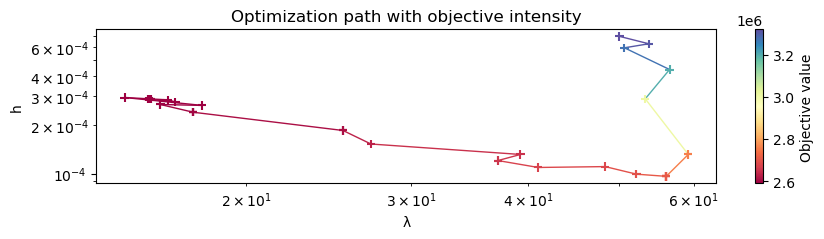

In [94]:
# Create a normalized colormap for the colorbar
normed = Normalize(vmin=obj_evals.min(), vmax=obj_evals.max())
cmap = plt.cm.Spectral
sm = ScalarMappable(cmap=cmap, norm=normed)

# Corrected plot with a properly defined colorbar

plt.figure(figsize=(10, 2))

# Plotting the optimization path with color mapped to normalized objective values
for i in range(len(res_1.allvecs) - 1):
    plt.plot(
        x_vals[i:i+2],
        y_vals[i:i+2],
        color=cmap(normed(obj_evals_1[i])),  # Use the normalized colormap for line colors
        linewidth=1,
    )

# Scatter points for visualization
scatter = plt.scatter(x_vals, y_vals, c=obj_evals, marker='+', cmap=cmap, norm=normed, zorder=5)
plt.colorbar(scatter, label="Objective value")  # Add colorbar linked to scatter points

# Labels and titles
plt.title("Optimization path with objective intensity")
plt.xlabel('λ')
plt.ylabel('h')
plt.yscale('log')
plt.xscale('log')
#plt.xlim(120, 130);    plt.ylim(3.7e-4, 4.1e-4)
plt.show()


### LM-BFGS-B

Derivative free:

In [111]:
print('{0:^5s}|{1:^11s}|{2:^11s}|{3:^11s}|{4:^9s}|{5:^3s}|{6:^11s}|'.format('#','λ', 'h','f(λ)','SSIM','CG','|Δf|') )
print('–'*68)
# Run algorithm
opti_nits = 0;    obj_evals = [];    points = []

start = time.time()
res_2 = minimize(obj_eval_a, asarray([50.0, 7e-4]), method='L-BFGS-B', bounds=[(Λᵪ[0], Λᵪ[1]), (Hᵪ[0], Hᵪ[1])],  jac = '2-point',
               callback = callback, options = {'disp':True, 'maxiter':50, 'return_all': True,  'ftol':1e-15, 'maxcor':5 } )
print('')
print(res_2)
end = time.time()
print('{0:.0f} min {1:.0f} s'.format((end-start)//60, (end-start)%60))

  #  |     λ     |     h     |   f(λ)    |  SSIM   |CG |   |Δf|    |
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
  0  | 1.764e+01 | 2.469e-04 | 2.593e+06 | 0.5728  | 4 |    inf    |
  1  | 1.828e+01 | 2.578e-04 | 2.592e+06 | 0.5715  | 4 | 1.222e+03 |
  2  | 1.797e+01 | 2.557e-04 | 2.591e+06 | 0.5720  | 4 | 4.923e+02 |
  3  | 1.782e+01 | 2.569e-04 | 2.591e+06 | 0.5721  | 4 | 1.340e+02 |
  4  | 1.697e+01 | 2.665e-04 | 2.591e+06 | 0.5724  | 4 | 6.260e+02 |
  5  | 1.627e+01 | 2.784e-04 | 2.590e+06 | 0.5726  | 4 | 4.254e+02 |
  6  | 1.599e+01 | 2.841e-04 | 2.590e+06 | 0.5726  | 4 | 8.619e+01 |
  7  | 1.587e+01 | 2.864e-04 | 2.590e+06 | 0.5726  | 4 | 1.418e+01 |
  8  | 1.587e+01 | 2.864e-04 | 2.590e+06 | 0.5726  | 4 | 2.615e-05 |

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 2589982.025942922
        x: [ 1.587e+01  2.864e-04]
      nit: 9
      jac: [-1.908e+02 -1.148e+06]
     nfev: 78
     njev: 26
 hess_i

In [112]:
obj_evals_2, points_2 = asarray(obj_evals).copy(),    asarray(points).copy()

In [113]:
points_2 = np.r_[[[50.0, 7e-4]],asarray(points_2)]    # add initial point

In [114]:
x_vals = points_2[:,0]
y_vals = points_2[:,1]
obj_evals_2 = np.r_[f_0, asarray(obj_evals_2)]

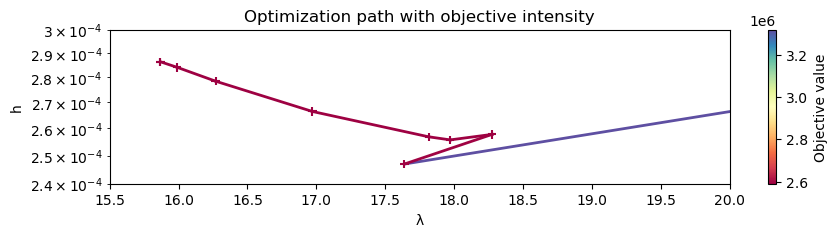

In [127]:
# Create a normalized colormap for the colorbar
normed = Normalize(vmin=obj_evals_2.min(), vmax=obj_evals_2.max())
cmap = plt.cm.Spectral
sm = ScalarMappable(cmap=cmap, norm=normed)

# Corrected plot with a properly defined colorbar

plt.figure(figsize=(10, 2))

# Plotting the optimization path with color mapped to normalized objective values
for i in range(len(obj_evals_2) - 1):
    plt.plot(
        x_vals[i:i+2],
        y_vals[i:i+2],
        color=cmap(normed(obj_evals_2[i])),  # Use the normalized colormap for line colors
        linewidth=2,
    )

# Scatter points for visualization
scatter = plt.scatter(x_vals, y_vals, c=obj_evals_2, marker='+', cmap=cmap, norm=normed, zorder=5)
plt.colorbar(scatter, label="Objective value")  # Add colorbar linked to scatter points

# Labels and titles
plt.title("Optimization path with objective intensity")
plt.xlabel('λ')
plt.ylabel('h')
plt.yscale('log')
#plt.xscale('symlog', linthresh=18)
plt.xlim(15.5, 20);    plt.ylim(2.4e-4, 3e-4)
plt.show()


In [128]:
obj_eval(res_2.x)

(array(2589982.02594292), array([1.19696702e+06, 6.58080777e+08]))

Use derivatives:

In [137]:
# This was not a good idea: errors accumulate
print('{0:^5s}|{1:^11s}|{2:^11s}|{3:^11s}|{4:^9s}|{5:^3s}|{6:^11s}|'.format('#','λ', 'h','f(λ)','SSIM','CG','|Δf|') )
print('–'*68)
# Run algorithm
opti_nits = 0;    obj_evals = [];    points = []

start = time.time()
res_4 = minimize(obj_eval, asarray([50.0, 7e-4]), method='L-BFGS-B', bounds=[(Λᵪ[0], Λᵪ[1]), (Hᵪ[0], Hᵪ[1])], jac = True,
               callback = callback, options = {'disp':True, 'maxiter':50, 'return_all': True,  'ftol':1e-15} )
print('')
print(res_4)
end = time.time()
print('{0:.0f} min {1:.0f} s'.format((end-start)//60, (end-start)%60))

  #  |     λ     |     h     |   f(λ)    |  SSIM   |CG |   |Δf|    |
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
  0  | 1.763e+01 | 2.468e-04 | 2.593e+06 | 0.5728  | 6 |    inf    |

  message: ABNORMAL: 
  success: False
   status: 2
      fun: 2593032.8007720574
        x: [ 1.763e+01  2.468e-04]
      nit: 1
      jac: [ 1.133e+06  7.983e+08]
     nfev: 31
     njev: 31
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
46 min 50 s


### Comparison

The points found have very similar objectives:

In [138]:
res_1.fun, res_2.fun

(2589978.299019214, 2589982.025942922)

In [139]:
res_1.x, res_2.x

(array([1.57560181e+01, 2.88234669e-04]),
 array([1.58678488e+01, 2.86387772e-04]))

The derivatives are not very informative since they are sharp around the optimiser:

In [131]:
Out[82], Out[128]

((array(2589978.29935917), array([1.20635568e+06, 6.54500988e+08])),
 (array(2589982.02594292), array([1.19696702e+06, 6.58080777e+08])))

Since L-BFGS-B took the smallest time, let's use its outputs as point of reference.

In [132]:
# Print final summary
General_SSIM = SSIMG(img, u, M,N,NN)
Base_SSIM    = SSIMG(img, ff, M,N,NN)

print('{0:^5s}|{1:^15s}|{2:^15s}'.format('i','SSIM(ū,u)','SSIM(ū,f)'))
print('–'*35)
for nn in range(NN):    print('{0:^5d}|{1:^15.8g}|{2:^15.8g}'.format(nn, General_SSIM[1][nn], Base_SSIM[1][nn] ))
print('–'*35)
print('Mean |{0:^15.8g}|{1:^15.8g}'.format(General_SSIM[0], Base_SSIM[0]))

  i  |  SSIM(ū,u)   |   SSIM(ū,f)   
–––––––––––––––––––––––––––––––––––
  0  |  0.64571069   |   0.601554    
  1  |  0.56372753   |  0.51840742   
  2  |  0.56088352   |  0.48932307   
  3  |  0.61832259   |  0.57157184   
  4  |  0.49521309   |  0.47812873   
  5  |  0.50698749   |  0.45925629   
  6  |  0.53343603   |  0.47952359   
  7  |  0.59982968   |  0.55631229   
  8  |  0.57596767   |  0.53479609   
  9  |  0.60560574   |  0.53890209   
 10  |  0.63589028   |  0.59822707   
 11  |  0.54975565   |  0.49251023   
 12  |  0.58270393   |  0.53799929   
 13  |  0.53710495   |  0.45948854   
 14  |  0.57765562   |  0.51505198   
–––––––––––––––––––––––––––––––––––
Mean |   0.5725863   |  0.52207017   


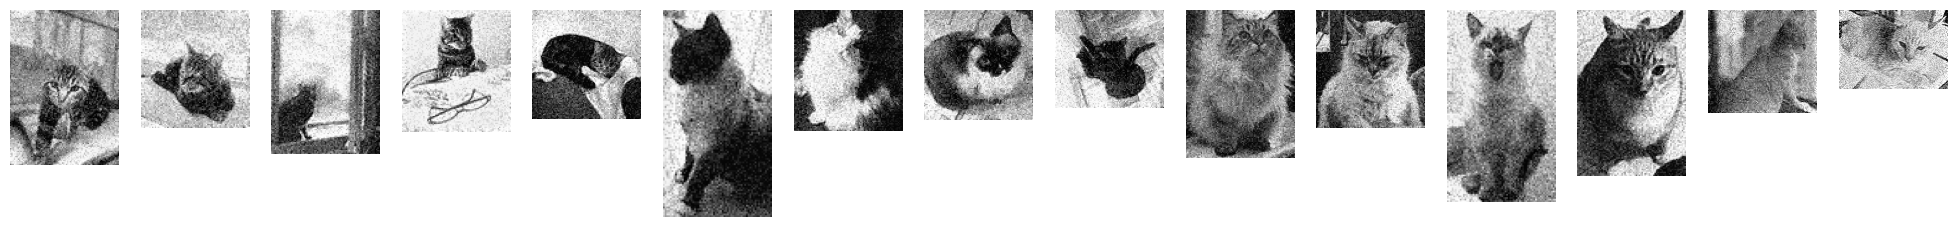

In [133]:
# Application of subblock but projected back
U_ff = [u[ nn].reshape(M[nn],N[nn]) for nn in range(NN)]

fig, ax = plt.subplots(1, NN, figsize=(25,5))

for i in range(NN):
    ax[i].imshow(   U_ff[i], cmap='gray');    ax[i].axis('off');    ax[i].set_anchor('N')
    
fig.subplots_adjust(hspace=0.5)
plt.show()

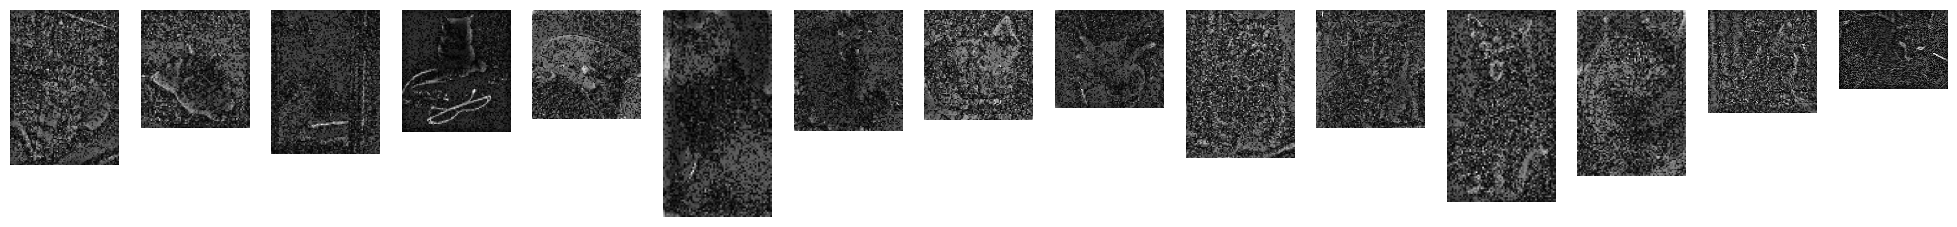

In [134]:
# Method of noise:
U_ff = [abs(u-ff)[ nn].reshape(M[nn],N[nn]) for nn in range(NN)]

fig, ax = plt.subplots(1, NN, figsize=(25,5))

for i in range(NN):
    ax[i].imshow(   U_ff[i], cmap='gray');    ax[i].axis('off');    ax[i].set_anchor('N')
    
fig.subplots_adjust(hspace=0.5)
plt.show()

In [135]:
np.concatenate(u-ff).mean(), np.concatenate(u-ff).std(),  np.concatenate(u-uT).mean(), np.concatenate(u-uT).std()

(7.850931271680303e-15,
 14.516356619832537,
 -1.1120536765282822,
 24.66790693619409)

In [136]:
np.concatenate(uT-ff).mean(), np.concatenate(uT-ff).std()

(1.11205367652829, 29.28248803756597)

In [141]:
obj_eval(res_2.x)

(array(2589982.02589905), array([1.19696702e+06, 6.58080777e+08]))

---

## Results

<div class="alert alert-block alert-info">
    
Here we display the following images:
1. Best objective
3. Original noisy
4. Original image
</div>

In [142]:
res_2.fun

2589982.025942922

In [143]:
folder = 'Images/Catset/Training_Clean'

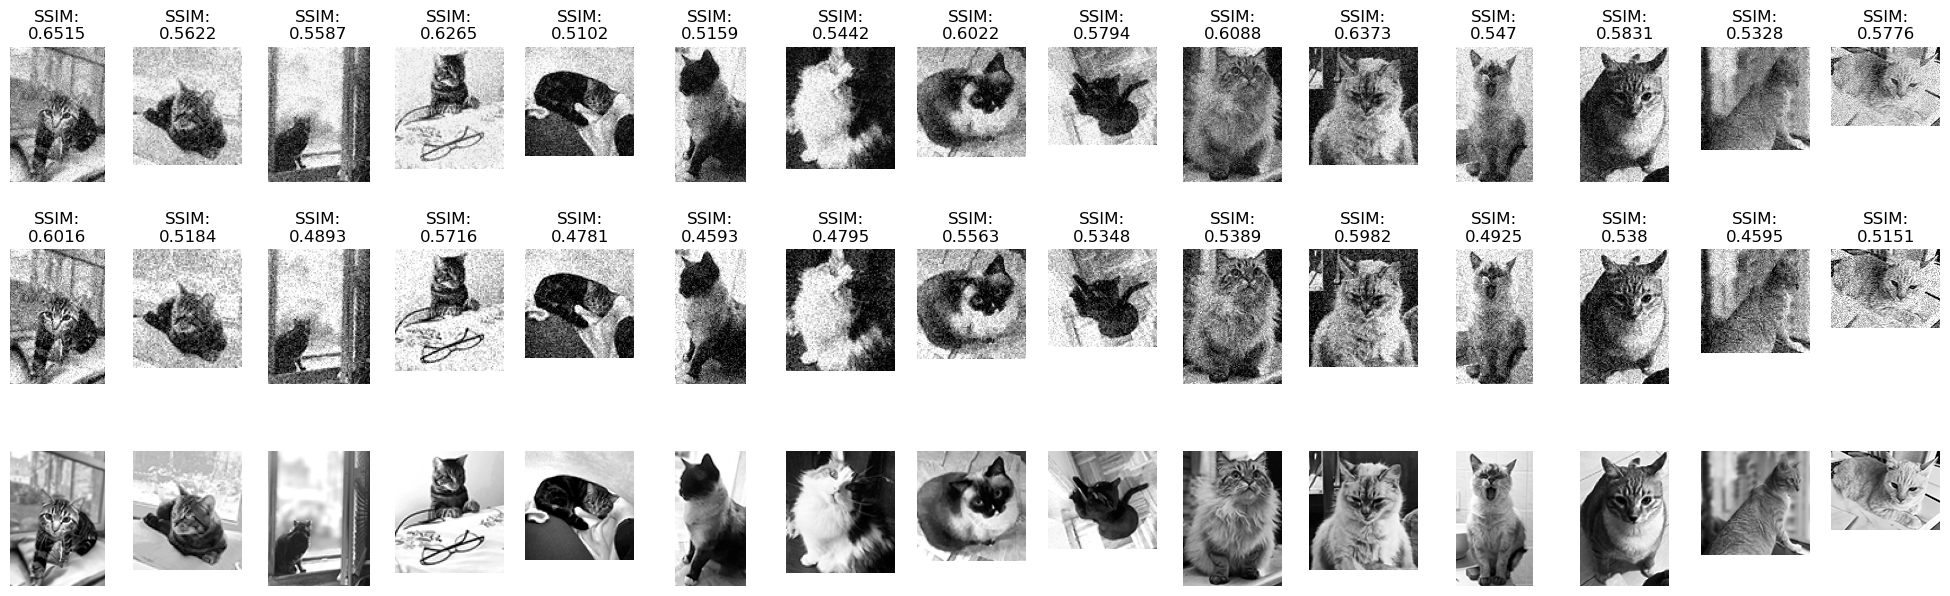

In [144]:
# Application of subblock but projected back
U_ff = [u[nn].reshape(M[nn],N[nn]) for nn in range(NN)]
U_ff = [rescale_intensity(U_ff[nn], out_range='uint8') for nn in range(NN)]
co = SSIMG(img,U_ff, M,N, NN)[1]
cu = SSIMG(img,f, M,N, NN)[1]

fig, ax = plt.subplots(3, NN, figsize=(25,7))

for i in range(NN):
    # Recovered
    ax[0,i].imshow(   U_ff[i], cmap='gray');    ax[0,i].axis('off');    ax[0,i].set_anchor('N');    ax[0,i].set_title('SSIM:\n' + str(around(co[i],4)));
    # Noisy
    ax[1,i].imshow(   f[i], cmap='gray');    ax[1,i].axis('off');    ax[1,i].set_anchor('N');    ax[1,i].set_title('SSIM:\n' + str(around(cu[i],4)));
    # Clean
    ax[2,i].imshow(   img[i], cmap='gray');    ax[2,i].axis('off');    ax[2,i].set_anchor('N');
    
fig.subplots_adjust(hspace=0.5)
plt.show()

In [145]:
# Summary of SSIM
print('{0:^5s}|{1:^18s}|{2:^18s}'.format('i','SSIM(u,ū)', 'SSIM(f,ū)'))
print('–'*40)
for nn in range(NN):    print('{0:^5d}|{1:^17.11g}|{2:^17.11g}'.format(nn, co[nn], cu[nn] ))
print('–'*40)
print('{0:^5s}|{1:^17.11g}|{2:^17.11g}'.format('M', np.mean(co), np.mean(cu) ))

  i  |    SSIM(u,ū)    |    SSIM(f,ū)     
––––––––––––––––––––––––––––––––––––––––
  0  |  0.65153512241  |  0.60155399658  
  1  |  0.56217216796  |  0.51840741833  
  2  |  0.55871769213  |  0.48932307095  
  3  |  0.62650797416  |  0.57157183597  
  4  |  0.51016498187  |  0.47812873353  
  5  |  0.51587157205  |  0.45925628857  
  6  |  0.54416660505  |  0.47952358796  
  7  |  0.60218495538  |  0.55631229274  
  8  |  0.5794444813   |  0.53479608568  
  9  |  0.60883037881  |  0.53890209172  
 10  |  0.6373312624   |  0.59822707025  
 11  |  0.54702077953  |  0.49251023376  
 12  |  0.58314475942  |  0.53799928841  
 13  |  0.53279596323  |  0.45948853827  
 14  |  0.57756955778  |  0.51505198012  
––––––––––––––––––––––––––––––––––––––––
  M  |  0.57583055023  |  0.52207016752  


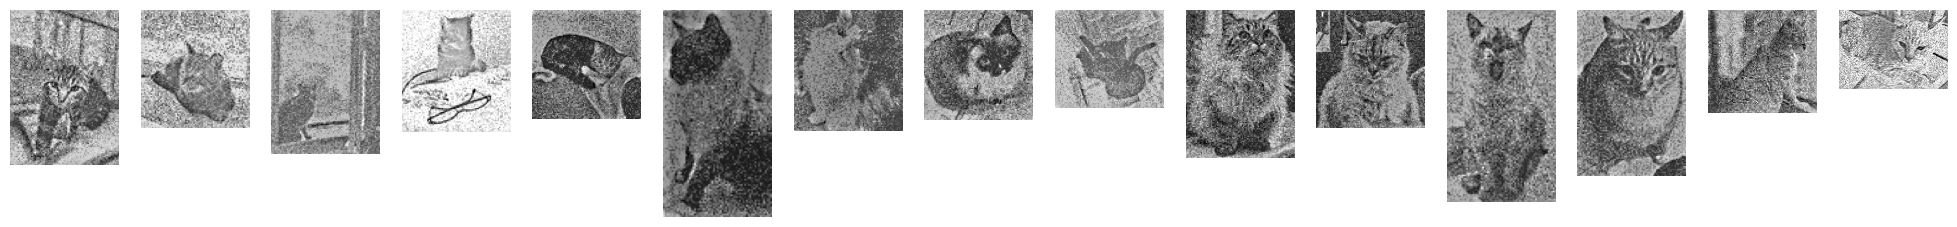

In [146]:
# Plot of adjoints
P_ff = [p[ nn].reshape(M[nn],N[nn]) for nn in range(NN)]

fig, ax = plt.subplots(1, NN, figsize=(25,5))

for i in range(NN):
    ax[i].imshow(   P_ff[i], cmap='gray');    ax[i].axis('off');    ax[i].set_anchor('N')
    
fig.subplots_adjust(hspace=0.5)
plt.show()

<div class="alert alert-block alert-danger">
Output
</div>

In [147]:
folder_Recovered = Path(folder).parent.as_posix() + '/Training_Recovered_Bi-PC/'
Path(folder_Recovered).mkdir(parents=True, exist_ok=True)            # Create directory if not already available

In [148]:
Recovered_Names = ['TR_' + '0{}.png'.format(i+1) if i < 9 else 'TR_' + '{}.png'.format(i+1) for i in range(NN)]
[imwrite(folder_Recovered + Recovered_Names[nn], U_ff[nn]) for nn in range(NN)];

<div class="alert alert-block alert-danger">

We can check the result against optimising just $\lambda$ for fixed $h$:
</div>

In [149]:
res_2.fun < 2638524.19688096

True

In [150]:
obj_eval([ 7.4836278460648264, (40**-2)])

(array(2638524.19694624), array([2.47058101e+06, 2.88449196e+08]))

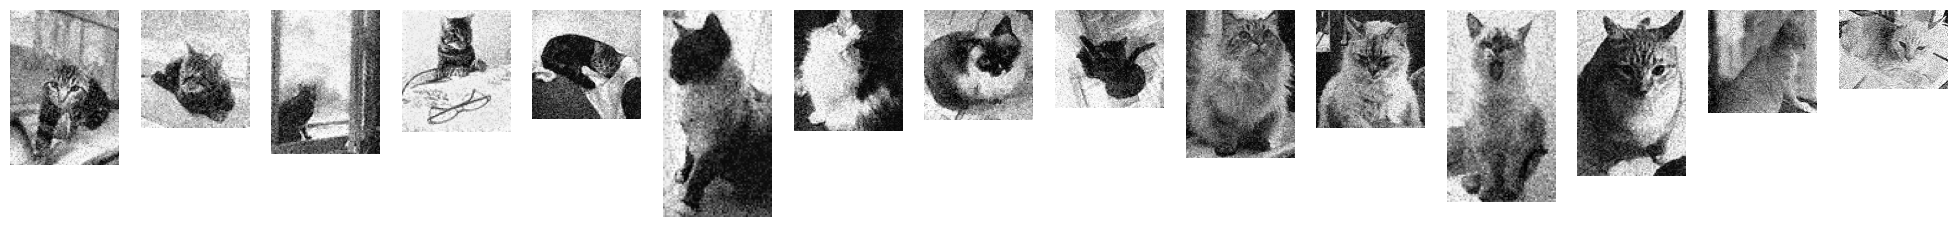

In [151]:
# Application of subblock but projected back
U_ff = [u[ nn].reshape(M[nn],N[nn]) for nn in range(NN)]

fig, ax = plt.subplots(1, NN, figsize=(25,5))

for i in range(NN):
    ax[i].imshow(   U_ff[i], cmap='gray');    ax[i].axis('off');    ax[i].set_anchor('N')
    
fig.subplots_adjust(hspace=0.5)
plt.show()

In [152]:
SSIMG(img, u, M,N,NN)[0]

0.5719333024169401

# Validation with testing set

<div class="alert alert-block alert-danger">
To reduce memory requirements, the following will overwrite some of the structures built before in the notebook. This is due to the independence of the inputs: the new data is not assumed to be of the same shape as the training data, hence new kernels and windows are needed. 
</div>

In [153]:
res_2.x

array([1.58678488e+01, 2.86387772e-04])

In [154]:
λ = res_2.x[0]
σ = res_2.x[1]**-0.5

In [155]:
res_2.x[1]**-0.5

59.091193852673676

<div class="alert alert-block alert-info">
We load the validation data base which has two subsets:

<b>a.</b> A clean images dataset, and
    
<b>b.</b> A noisy images dataset.
</div>

In [156]:
folder_Validation_C = Path(folder).parent.as_posix() + '/Validation_Clean/'
folder_Validation_N = Path(folder).parent.as_posix() + '/Validation_Noisy/'

In [157]:
# Read clean images
img = imread_collection( folder_Validation_C + '/*.png', conserve_memory = False)       # Image read
img  = asarray([255 * img_as_float(rescale_intensity(i, out_range='uint8')) for i in img], dtype='object')
M, N = asarray([i.shape for i in img]).T                                    # Store image sizes

NN  = len(img)                                                              # training set size
print('{0} images with average size (M̅ᵥ,N̅ᵥ) = ({1},{2})'.format(NN, M.mean().astype(int), N.mean().astype(int) ))

11 images with average size (M̅ᵥ,N̅ᵥ) = (97,96)


In [158]:
# Read noisy images
f = imread_collection( folder_Validation_N + '/*.png', conserve_memory = False)       # Image read
f = asarray([255 * img_as_float(rescale_intensity(i, out_range='uint8')) for i in f], dtype='object')

if f.shape[0] != NN:
    print('Error: The number of images read is different than the number of images in the dataset.')
else:
    print(NN, 'images read.')

11 images read.


Display images

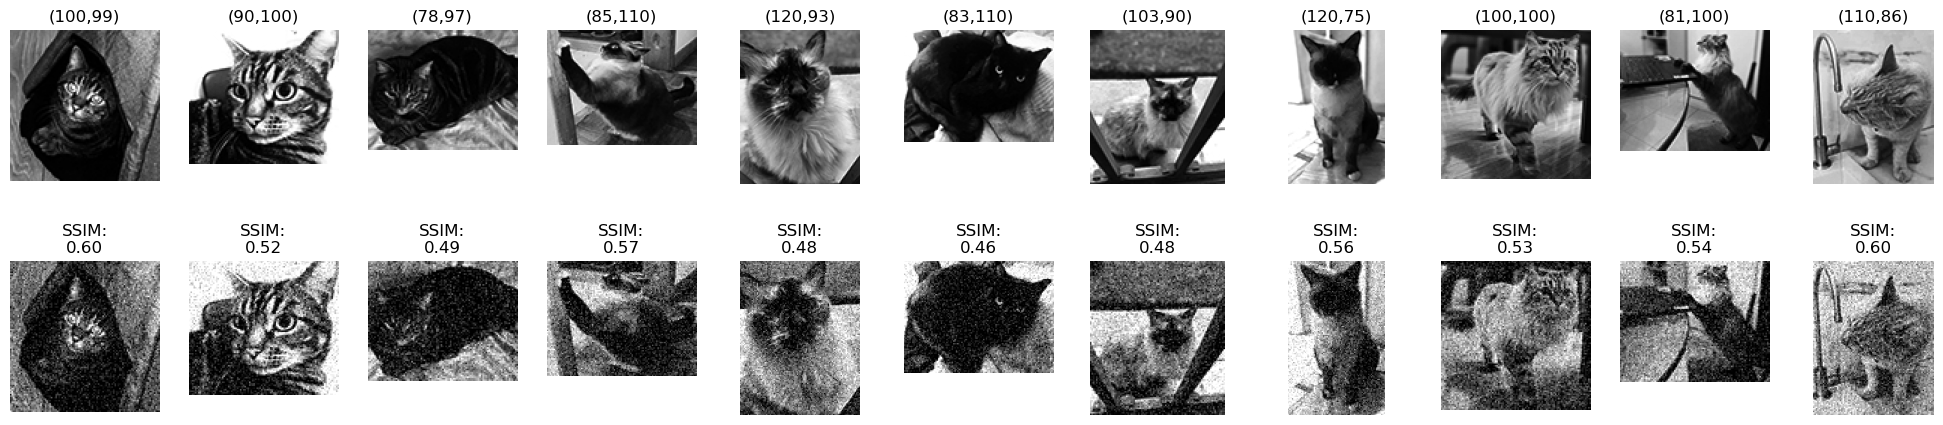

In [159]:
# Clean and noisy images: title is M × N

fig, ax = plt.subplots(2, NN, figsize=(25,5))

for i in range(NN):
    ax[0,i].imshow( img[i], cmap='gray')
    ax[0,i].set_title('({0},{1})'.format(M[i],N[i]));    ax[0,i].axis('off');    ax[0,i].set_anchor('N')
    
    ax[1,i].imshow( f[i], cmap='gray')
    ax[1,i].set_title('SSIM:\n{0:.2f}'.format(Quality[1][i]));    ax[1,i].axis('off');    ax[1,i].set_anchor('N')
    
fig.subplots_adjust(hspace=0.5)
plt.show()

<div class="alert alert-block alert-warning">
New kernels are needed:
</div>

In [170]:
SWindowV = [[[60, 71, 49], [61, 59, 70], [50, 82, 48], [81, 38, 72], [39, 83, 27], [92, 93, 37], [104, 28, 94], [103, 62, 69], [105, 40, 73], [26, 84, 80], 
             [47, 58, 17], [51, 16, 115], [91, 36, 29], [15, 114, 95], [116, 102, 5], [6, 25, 117], [4, 57, 113], [106, 14, 18], [52, 90, 85], [63, 68, 7], 
             [35, 96, 46], [79, 101, 24], [41, 30, 74], [3, 112, 86], [56, 118, 107], [19, 2, 42], [64, 8, 75], [34, 13, 53], [97, 67, 89], [100, 45, 78], 
             [31, 108, 9], [20, 119, 111], [65, 55, 32], [87, 23, 66], [44, 109, 12], [76, 77, 110], [11, 98, 88], [33, 54, 1], [99, 43, 120], [22, 10, 0], 
             [21]], 
            [[60, 59, 71], [61, 49, 70], [50, 72, 48], [82, 81, 69], [62, 58, 38], [51, 39, 92], [47, 80, 93], [73, 40, 83], [28, 37, 91], [57, 27, 68], 
             [79, 102, 63], [103, 94, 104], [90, 29, 18], [84, 52, 17], [36, 46, 16], [114, 41, 74], [26, 105, 115], [53, 56, 78], [113, 67, 45], 
             [7, 101, 89], [30, 42, 19], [95, 5, 85], [64, 15, 75], [112, 116, 88], [31, 35, 25], [8, 77, 100], [55, 6, 43], [20, 106, 54], [24, 9, 86], 
             [66, 34, 4], [65, 14, 10], [96, 117, 32], [44, 110, 111], [87, 99, 97], [21, 107, 23], [13, 76, 98], [12, 33, 3], [22, 118, 108], [11, 1, 119], 
             [2, 109, 0], [120]], 
            [[60, 61, 59], [49, 71, 72], [48, 70, 62], [50, 58, 73], [47, 69, 51], [63, 83, 38], [68, 52, 46], [82, 74, 64], [57, 37, 56], [36, 80, 40], 
             [84, 53, 41], [85, 39, 81], [45, 65, 35], [55, 67, 79], [75, 28, 25], [54, 66, 27], [26, 93, 96], [78, 42, 95], [24, 44, 76], [43, 86, 34], 
             [23, 33, 90], [92, 29, 77], [94, 30, 87], [91, 31, 16], [88, 104, 14], [107, 97, 32], [13, 89, 17], [100, 22, 105], [18, 15, 102], [118, 20, 98],
             [106, 103, 12], [19, 108, 7], [4, 101, 113], [6, 114, 99], [117, 21, 8], [109, 116, 9], [115, 11, 5], [110, 0, 2], [3, 112, 119], [111, 10, 120],
             [1]], 
            [[60, 61, 71], [49, 59, 72], [48, 70, 50], [62, 58, 73], [82, 38, 83], [37, 51, 47], [69, 84, 39], [63, 74, 81], [36, 27, 93], [94, 26, 46], 
             [95, 40, 57], [52, 85, 28], [64, 105, 96], [25, 68, 80], [35, 75, 92], [15, 86, 16], [45, 56, 24], [29, 53, 17], [97, 104, 103], [106, 76, 91],
             [79, 41, 107], [67, 23, 14], [34, 65, 4], [115, 44, 87], [13, 118, 116], [42, 108, 6], [2, 30, 5], [12, 55, 98], [102, 22, 117], [109, 18, 90],
             [54, 119, 33], [66, 78, 19], [3, 114, 7], [31, 120, 1], [77, 11, 43], [89, 32, 113], [8, 20, 101], [0, 88, 21], [112, 100, 10], [9, 111, 99],
             [110]], 
            [[60, 71, 49], [59, 61, 70], [72, 48, 50], [82, 38, 81], [69, 58, 62], [83, 39, 93], [37, 73, 47], [51, 84, 92], [27, 80, 40], [94, 28, 36], 
             [104, 57, 26], [63, 95, 74], [68, 103, 46], [29, 91, 25], [15, 105, 16], [52, 79, 85], [41, 115, 35], [17, 114, 102], [75, 106, 90], 
             [116, 67, 14], [5, 56, 64], [96, 4, 18], [101, 117, 113], [30, 6, 24], [53, 107, 45], [78, 19, 65], [86, 34, 89], [7, 42, 31], [3, 97, 108], 
             [66, 23, 13], [12, 118, 55], [54, 76, 44], [43, 77, 112], [1, 33, 8], [100, 119, 88], [2, 87, 20], [22, 109, 98], [11, 0, 111], [99, 120, 32], 
             [9, 21, 110], [10]], 
            [[60, 59, 71], [49, 61, 70], [50, 72, 48], [81, 58, 82], [38, 69, 62], [39, 83, 47], [37, 80, 93], [51, 57, 73], [92, 40, 28], [68, 27, 84], 
             [46, 79, 36], [63, 91, 56], [74, 26, 94], [52, 104, 41], [103, 67, 29], [53, 16, 95], [25, 45, 78], [90, 102, 64], [35, 75, 85], [105, 17, 115],
             [55, 106, 66], [30, 114, 15], [77, 14, 96], [18, 34, 42], [24, 76, 5], [7, 54, 89], [113, 65, 44], [101, 112, 6], [86, 116, 31], [19, 88, 43], 
             [33, 13, 100], [23, 3, 87], [97, 117, 4], [107, 22, 20], [99, 32, 8], [119, 118, 12], [2, 108, 110], [111, 21, 9], [98, 10, 11], [109, 120, 1],
             [0]],
            [[60, 61, 59], [71, 49, 70], [50, 48, 72], [62, 58, 81], [82, 69, 39], [51, 73, 38], [63, 83, 80], [47, 57, 37], [92, 40, 68], [93, 84, 52], 
             [28, 29, 94], [91, 74, 27], [104, 56, 36], [64, 26, 67], [79, 103, 46], [53, 41, 105], [85, 102, 95], [16, 101, 113], [17, 96, 75], 
             [78, 114, 42], [65, 90, 115], [35, 30, 18], [15, 55, 45], [54, 106, 66], [25, 19, 112], [8, 89, 7], [116, 111, 76], [86, 5, 6], [100, 77, 31], 
             [107, 88, 4], [24, 117, 44], [14, 20, 9], [32, 43, 110], [97, 34, 99], [108, 13, 87], [10, 23, 98], [109, 21, 118], [3, 33, 2], [119, 12, 22], 
             [1, 120, 11], [0]],
            [[60, 71, 49], [61, 59, 38], [82, 70, 72], [48, 50, 93], [83, 37, 81], [27, 39, 58], [62, 94, 26], [104, 16, 47], [36, 69, 73], [51, 28, 105], 
             [15, 5, 84], [92, 115, 80], [116, 95, 17], [40, 103, 4], [46, 6, 57], [25, 74, 63], [106, 68, 14], [117, 114, 85], [29, 79, 91], [35, 52, 3], 
             [107, 96, 18], [56, 102, 24], [90, 41, 45], [30, 67, 34], [118, 86, 7], [13, 75, 78], [113, 2, 97], [64, 53, 23], [66, 55, 33], [108, 119, 44],
             [101, 19, 89], [12, 42, 1], [112, 8, 11], [76, 22, 100], [65, 77, 31], [87, 54, 88], [98, 99, 0], [109, 110, 120], [20, 43, 32], [111, 9, 21], 
             [10]],
            [[60, 49, 71], [61, 59, 50], [48, 72, 70], [38, 39, 62], [82, 51, 27], [81, 37, 28], [83, 40, 58], [69, 73, 47], [93, 29, 17], [16, 84, 52], 
             [92, 63, 26], [104, 41, 30], [94, 74, 75], [80, 64, 36], [5, 53, 57], [18, 54, 6], [68, 46, 95], [85, 15, 19], [105, 42, 103], [8, 91, 7], 
             [102, 25, 43], [31, 4, 65], [45, 114, 86], [20, 9, 115], [79, 90, 67], [96, 56, 106], [35, 32, 76], [21, 116, 14], [24, 34, 10], [107, 87, 113],
             [117, 3, 78], [66, 97, 112], [33, 101, 44], [108, 55, 100], [89, 23, 109], [118, 77, 11], [98, 119, 88], [12, 2, 1], [111, 22, 120],
             [110, 13, 0], [99]],
            [[60, 71, 61], [49, 59, 50], [70, 72, 48], [82, 81, 38], [39, 62, 58], [83, 51, 73], [69, 93, 27], [37, 92, 28], [63, 84, 47], [40, 94, 74], 
             [57, 80, 103], [64, 52, 104], [68, 91, 36], [29, 26, 16], [17, 105, 95], [75, 85, 86], [41, 25, 115], [54, 53, 114], [96, 56, 65], [46, 42, 106],
             [30, 76, 15], [45, 102, 116], [97, 79, 90], [18, 87, 5], [35, 6, 14], [98, 107, 67], [113, 78, 109], [117, 19, 7], [24, 66, 108], [118, 31, 89],
             [101, 43, 34], [55, 119, 120], [8, 4, 44], [112, 23, 13], [32, 20, 33], [21, 3, 111], [77, 2, 9], [88, 12, 99], [10, 100, 22], [11, 110, 1], 
             [0]],
            [[60, 71, 49], [61, 59, 70], [82, 38, 48], [50, 72, 93], [27, 83, 58], [37, 81, 62], [39, 94, 26], [80, 104, 69], [28, 16, 92], [47, 15, 73], 
             [40, 63, 51], [5, 68, 105], [36, 52, 57], [17, 74, 4], [91, 53, 6], [84, 29, 25], [115, 103, 86], [90, 64, 46], [14, 41, 75], [116, 54, 95], 
             [35, 85, 45], [114, 18, 65], [7, 42, 102], [67, 79, 56], [24, 31, 87], [55, 3, 43], [106, 30, 96], [19, 113, 66], [78, 97, 107], [20, 120, 33],
             [117, 32, 119], [8, 101, 9], [108, 23, 34], [76, 2, 109], [98, 77, 44], [22, 13, 118], [100, 89, 99], [21, 112, 10], [12, 0, 1], [11, 88, 111],
             [110]]
           ]

In [171]:
num_windows = np.empty(NN, dtype=int)
all_Windows = []
k_weight    = np.empty(NN)
Sub_Γℓ = []

print('{0:^4}|{1:^5}|{2:^5}|{3:^7}|{4:^8}|{5:^6}|{6:^14}|{7:^8}|'.format( 'id', 'Mᵢ', 'Nᵢ', 'Mᵢ×Nᵢ', 'Γℓ[GB]', 'SSIM', 'Windows','Setup' ))
print('–'*65)
for nn in range(NN):
    nm  = M[nn] * N[nn]
    ram_size = np.float64(1).itemsize * np.prod([nm,nm]) / (1024 ** 3)
    print('{0:^4}|{1:^5d}|{2:^5d}|{3:^7d}|{4:^8.2f}|{5:^6.2f}|'.format(nn, M[nn], N[nn], nm, ram_size, Quality[1][nn] ), end = '')
    
    '''
        Kernel Setup
    '''
    Fᵖᵃᵈ = pad(f[nn], ρ, mode='constant')
    X = sliding_window_view(Fᵖᵃᵈ, (ρ̂,ρ̂)).reshape(nm, ρ̂**2)
    
    '''Build windows'''
    start = time.time()
    # determine windows of features by their mis
    if 'SWindowV' in globals():
        windows = SWindowV[nn]
    else:
        res_idx = clf.make_mi_scores(X, around(f[nn]).astype(int).ravel())
        windows = clf.get_mis_windows(res_idx)
        
    # Measure and store
    all_Windows.append(windows)
    num_windows[nn] = len(windows)
    end = time.time()
    print(' {0:^2d} ({1:5.2f} s) |'.format( num_windows[nn], 0+ end-start ), end = '')
    
    '''Weights'''
    # Compute kernel weights: equal weights that sup up to 1 or no weighting:
    k_weight[nn] = 1.0/num_windows[nn]
    
    '''Kernel as abstract object'''
    def W(σ, n = 64, m = 8, p = 8, Other_Setup = None):
        '''
        Set up the subkernel matrices that constitute the extended Gaussian ANOVA kernel

        Note
        ----
        Using the NFFT-approach, the kernel matrices are never computed explicitly.

        Parameters
        ----------
        X : ndarray
            The training data matrix.
        σ : float
            Shape of the kernel.
        n : even int
            The NFFT expansion degree.
        m : int ≤ max(N,M)
            Window cutoff.
        p : int
            Smoothness of the window function.

        Returns
        -------
        SubKernels : list of fastadj.AdjacencyMatrix
            Subkernel matrices for each window of features according to the selected window scheme.
        '''

        # Bound on window cutoff [Lemma 3.4]
        if n < max([4*m,12]):
            print('Changing n = {} to {}'.format(n, max([4*m,12])))
            n = max([4*m,12])

        # Setup approximation parameters
        NFFT_setup = fastadj.AccuracySetup(n,m,p,0,0)   if Other_Setup is None else   Other_Setup

        # Set diagonal → 0, since FastAdjacency package is targeted at graph Laplacian with zeros at the diagonal
        return [fastadj.AdjacencyMatrix(X[:,windows[l]], σ, NFFT_setup, 0.0) for l in range(num_windows[nn])]
    
    start = time.time()
    Sub_Γℓ.append( W(σ, Other_Setup = 'default') )
    end = time.time()
    print('{0:5.2f} s'.format( end - start ))
    
    print('–'*65)

 id | Mᵢ  | Nᵢ  | Mᵢ×Nᵢ | Γℓ[GB] | SSIM |   Windows    | Setup  |
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 0  | 100 | 99  | 9900  |  0.73  | 0.60 | 41 ( 0.00 s) | 0.30 s
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 1  | 90  | 100 | 9000  |  0.60  | 0.52 | 41 ( 0.00 s) | 0.26 s
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 2  | 78  | 97  | 7566  |  0.43  | 0.49 | 41 ( 0.00 s) | 0.22 s
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 3  | 85  | 110 | 9350  |  0.65  | 0.57 | 41 ( 0.00 s) | 0.28 s
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 4  | 120 | 93  | 11160 |  0.93  | 0.48 | 41 ( 0.00 s) | 0.32 s
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 5  | 83  | 110 | 9130  |  0.62  | 0.46 | 41 ( 0.00 s) | 0.28 s
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 6  | 103 | 90  | 9270  |  0.64  | 0.48 | 41 ( 0.00 s) | 0.27 s
––––––––––––––––––––––––

In [172]:
nm   = np.prod([M,N],0).sum()                  # Total problem size
nm_s = np.prod([M,N],0)                        # Particular sizes
cuts = np.r_[0,np.cumsum(np.prod([M,N],0))]    # Indices to identify each subblock
# Check with [np.count_nonzero(np.concatenate(η)[ cuts[nn]:cuts[nn+1] ] - η[nn]) for nn in range(NN)]

In [173]:
Ones = [ones(M[nn] * N[nn]) for nn in range(NN)]

In [174]:
# Function to be executed in parallel
def compute_vector(nn, l, u):
    """Apply the function Sub_Γℓ[nn][l] to u[nn]"""
    #return funs[nn][l](u)
    return Sub_Γℓ[nn][l].apply(u)

In [175]:
def AK_n(nn):
    # Outer function selects the index nn and prepares the evaluator
    results = empty([num_windows[nn], nm_s[nn]])        # Initialize a structure to hold the results
    def AK(u):
        nonlocal nn  # Declare that nn is not a local variable
        """
        Approximate the matrix-vector product AK*u, where AK = w * (K_1 + K_2 + ... + K_L).

        Note
        ----
        Since this function serves a LinearOperator from scipy, only one variable can be passed as input parameter.
        Any other variable needed has to be global, so that they can still be used within this function

        Parameters
        ----------
        u : ndarray
            The vector, whose product AK*u with the matrix AK shall be approximated.

        Returns
        -------
        AKu : ndarray
            The approximated matrix-vector product AK*u.
        """
        
        # Apply matrix-vector multiplication in parallel
        with ProcessPoolExecutor(max_workers=8, mp_context=mp_fork) as executor:
            # Create all possible (nn, l) pairs and execute them in parallel
            futures = {executor.submit(compute_vector, nn, l, u): (nn, l) for l in range(num_windows[nn])}

            # Collect the results as they complete
            for future in concurrent.futures.as_completed(futures):
                nn, l = futures[future]
                try:
                    results[l] = future.result()
                except Exception as e:
                    print(f"An error occurred at (nn={nn}, l={l}): {e}")
        
        # Add up products and weight
        AKu = results.sum(0) * k_weight[nn]
        
        return AKu
    return AK

In [176]:
AKs = [AK_n(nn) for nn in range(NN)]

In [177]:
start = time.time()
η = [AKs[nn](Ones[nn]) for nn in range(NN)]
end = time.time()
print('Parallel application - 8: {0:.2f} s'.format( end - start ))

Parallel application - 8: 3.95 s


In [178]:
print('–'*80)
for nn in range(NN):
    print('id: {0:2d} – '.format(nn), end = '')
    nm  = M[nn] * N[nn]
    ram_size = np.float64(1).itemsize * np.prod([nm,nm]) / (1024 ** 3)
    print( '(Γℓ)_ℓ: {0:6.2f} [GB] – '.format(ram_size * num_windows[nn]), end = '' )
    # Approximate numerical range
    E_A = μ * η[nn].max()
    e_A = μ * η[nn].min() * nm/(nm-1)
    print('Ŵᶠᵃˢᵗ(B) - {0}:' +  7*' ' + '{0:5.2f}  {1:8.2e}'.format( E_A, e_A ) )
    print('–'*80)

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  0 – (Γℓ)_ℓ:  29.94 [GB] – Ŵᶠᵃˢᵗ(B) - {0}:       25.38  2.44e+00
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  1 – (Γℓ)_ℓ:  24.74 [GB] – Ŵᶠᵃˢᵗ(B) - {0}:       12.31  2.48e+00
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  2 – (Γℓ)_ℓ:  17.49 [GB] – Ŵᶠᵃˢᵗ(B) - {0}:       23.74  1.32e+00
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  3 – (Γℓ)_ℓ:  26.71 [GB] – Ŵᶠᵃˢᵗ(B) - {0}:       20.10  1.87e+00
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  4 – (Γℓ)_ℓ:  38.05 [GB] – Ŵᶠᵃˢᵗ(B) - {0}:       16.03  3.13e+00
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  5 – (Γℓ)_ℓ:  25.46 [GB] – Ŵᶠᵃˢᵗ(B) - {0}:       31.83  1.18e+00
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  6 – (Γℓ)_ℓ:  2

In [179]:
A = [LinearOperator((nm_s[nn],nm_s[nn]), dtype=np.float64, matvec=MatVecs(nn), rmatvec=MatVecs(nn)) for nn in range(NN)]

In [180]:
uT = asarray([i.flatten() for i in img], dtype='object')    # Flatten clean images
ff = asarray([i.flatten() for i in f], dtype='object')      # Flatten noisy samples

In [181]:
A[nn](Ones[nn])

array([15.86784879, 15.86784879, 15.86784879, ..., 15.86784879,
       15.86784879, 15.86784879])

In [182]:
# Basis change only depends on the dimension of each image, so we only have to define it once
not_e_1 = [ones(nm_s[nn]) for nn in range(NN)]
[setitem(not_e_1[nn], 0 , 0.0) for nn in range(NN)];

aux_h = [np.arange(nm_s[nn]) for nn in range(NN)]
aux_d = [np.reciprocal(np.sqrt( np.concatenate( ([nm_s[nn]], np.arange(2,nm_s[nn]+1) * np.arange(1,nm_s[nn]) ) ) ))  for nn in range(NN)]

In [183]:
def MV_basis_U_T(v, nn):
    '''
        Transpose of unitary transformation
    '''
    v = v if isinstance(v, np.ndarray) else asarray(v)    # Ensure an ndim array is given
            
    # We iteratively apply U.T to each slice
    U_T_v = aux_d[nn] * (np.roll( np.cumsum(v),1) - (aux_h[nn] * v))
    
    return asarray(U_T_v)

In [184]:
def MV_basis_U(v, nn):
    '''
        Unitary transformation
    '''
    v = v if isinstance(v, np.ndarray) else asarray(v)    # Ensure an ndim array is given
        
    # We iteratively apply U to each slice
    w   = aux_d[nn] * v
    U_v = ((w.sum() - np.cumsum(w)) * np.flip(not_e_1[nn])) - (aux_h[nn] * w) + w[0]
    
    return asarray(U_v)

In [185]:
all([allclose(MV_basis_U_T( MV_basis_U(Ones[nn],nn), nn), 1) for nn in range(NN)])

True

In [186]:
# Projections
Prec_RHS = asarray([MV_basis_U_T(ff[nn],nn) for nn in range(NN)], dtype='object')

In [187]:
# Define subblock of system
def MAM_op(nn):
    # Define matrix vector multiplications for a choice of nn
    def MV_basis_MAM(v):
        nonlocal nn
        '''
            Project back v, change basis by U, apply A, then U.T, and project; i.e., (P U.T A U) P.T v
        '''
        w = np.concatenate( ([0.0], v) )
        w = MV_basis_U_T( A[nn].dot( MV_basis_U( w, nn ) ), nn )
        return w[1:]

    return MV_basis_MAM

In [188]:
MAM = [LinearOperator((nm_s[nn]-1,nm_s[nn]-1), dtype=np.float64, matvec=MAM_op(nn), rmatvec=MAM_op(nn)) for nn in range(NN)]

In [189]:
Vs = zeros(nm_s[nn]);    Vs[0] = 1.0
allclose(MV_basis_U_T(  A[nn].dot(MV_basis_U( Vs, nn )), nn), λ*Vs)

True

In [190]:
# Define sub preconditioners
def UDU_op(nn):
    # Define matrix vector multiplications for a choice of nn
    def Proj_Prec_Diag(v):
        nonlocal nn
        '''
            Project back v, change basis by U, apply M, then U.T, and project; i.e., (P U.T A U) P.T v
        '''
        w = np.concatenate( ([0.0], v) )
        w = MV_basis_U_T( diag_P[nn] * MV_basis_U(w,nn), nn )
        return w[1:]

    return Proj_Prec_Diag

In [191]:
UDU = [LinearOperator((nm_s[nn]-1,nm_s[nn]-1), dtype=np.float64, matvec=UDU_op(nn), rmatvec=UDU_op(nn)) for nn in range(NN)]

In [192]:
η = asarray(η, dtype='object')

In [193]:
diag_P = η**-1    # Example for test

<div class="alert alert-block alert-info">
Evaluate objective:
</div>

In [194]:
u = asarray([i.copy() for i in ff], dtype='object')

In [195]:
def obj_eval_v(x):                  # ** Eval f ** #
    global u,   diag_P,   g_cg_it, cg_its
    global λ, h
    global Sub_Γℓ, η
    
    '''
        Evaluate state and return objective
    '''
    # Identify components
    λ, h = x
    σ = h**-0.5
    
    # If h changes, then update kernels and η
    if abs(Sub_Γℓ[0][0].sigma - σ) > 1e-10:             # All kernels share the same shape
        # Update Γₕ
        deque((ker.__setattr__('sigma', σ)   for nn in range(NN)   for ker in Sub_Γℓ[nn]), 0);
        # Update η
        η = asarray([AKs[nn](Ones[nn]) for nn in range(NN)], dtype='object')
    
    # Check feasibility for λ
    if λ < 0.0:        return 4*Snorm(u) + 1e+4     # In case something goes off, penalise negative values of λ
    
    # Build simple diagonal preconditioner [don't forget about μ]
    add(μ * η, λ, out = diag_P);    reciprocal(diag_P, out = diag_P);
    
    Prec_x_0 = asarray([MV_basis_U_T(u[nn],nn) for nn in range(NN)], dtype='object') / λ     # Project initial solution
    
    # Solve state and adjoint systems
    cg_its = [[],[]]
    for nn in range(NN):
        '''    State u    '''
        ## MAM x = g / s  ->  [sx] solves MAM uₒ = g, in particular we could take s = ‖g‖
        s = norm(Prec_RHS[nn][1:])
        g_cg_it = 0
        uₒ, status = cg(MAM[nn], Prec_RHS[nn][1:]/s, x0 = Prec_x_0[nn][1:]/s, rtol = 1e-10, maxiter = 25, M = UDU[nn], callback = solver_call)
        uₒ *= s
        #print( '{0:.2e} {1:.2e}'.format( norm(MAM[nn](uₒ) - Prec_RHS[nn][1:]), norm(MAM[nn](uₒ) - Prec_RHS[nn][1:])/norm( Prec_RHS[nn][1:] ) ))

        # Build solution out of blocks
        u[nn][1:] = λ * uₒ                   # Second block
        u[nn][0]  = Prec_RHS[nn][0].copy()   # First subblock
        u[nn] = MV_basis_U(u[nn],nn)         # Go back to original basis
    
        cg_its[0].append(g_cg_it)
        
    return array(Objective(u))

In [196]:
# Evaluate before getting results
obj_eval_v([λ,h]).item()

3079285.9088161318

<div class="alert alert-block alert-info">
    
Here we display the following images:
1. Recovered image
3. Original noisy
4. Original image
</div>

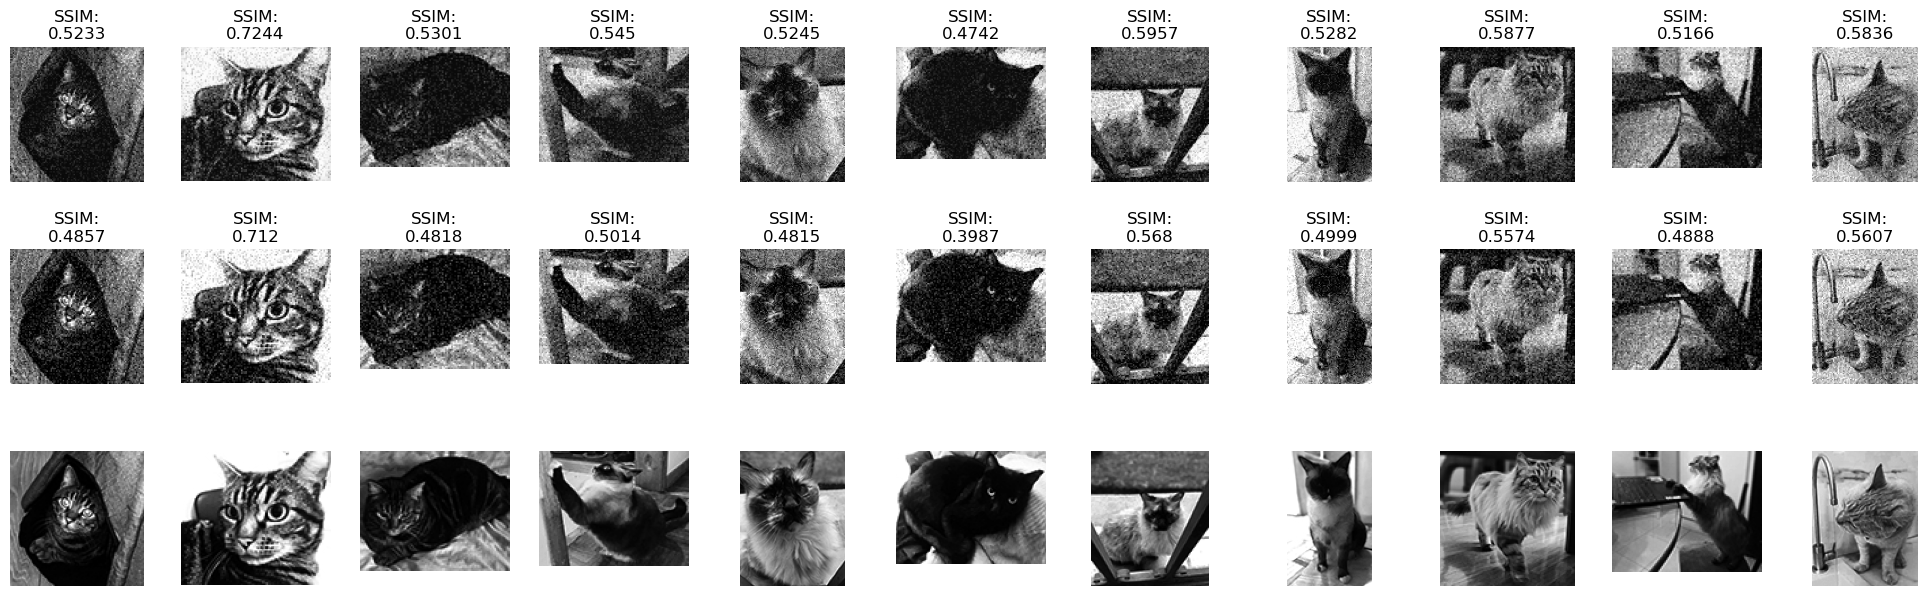

In [197]:
# Comparison of results
U_ff = [u[nn].reshape(M[nn],N[nn]) for nn in range(NN)]
U_ff = [rescale_intensity(U_ff[nn], out_range='uint8') for nn in range(NN)]
co = SSIMG(img,U_ff, M,N, NN)[1]
cu = SSIMG(img,f, M,N, NN)[1]

fig, ax = plt.subplots(3, NN, figsize=(25,7))

for i in range(NN):
    # Recovered
    ax[0,i].imshow(   U_ff[i], cmap='gray');    ax[0,i].axis('off');    ax[0,i].set_anchor('N');    ax[0,i].set_title('SSIM:\n' + str(around(co[i],4)));
    # Noisy
    ax[1,i].imshow(   f[i], cmap='gray');    ax[1,i].axis('off');    ax[1,i].set_anchor('N');    ax[1,i].set_title('SSIM:\n' + str(around(cu[i],4)));
    # Clean
    ax[2,i].imshow(   img[i], cmap='gray');    ax[2,i].axis('off');    ax[2,i].set_anchor('N');
    
fig.subplots_adjust(hspace=0.5)
plt.show()

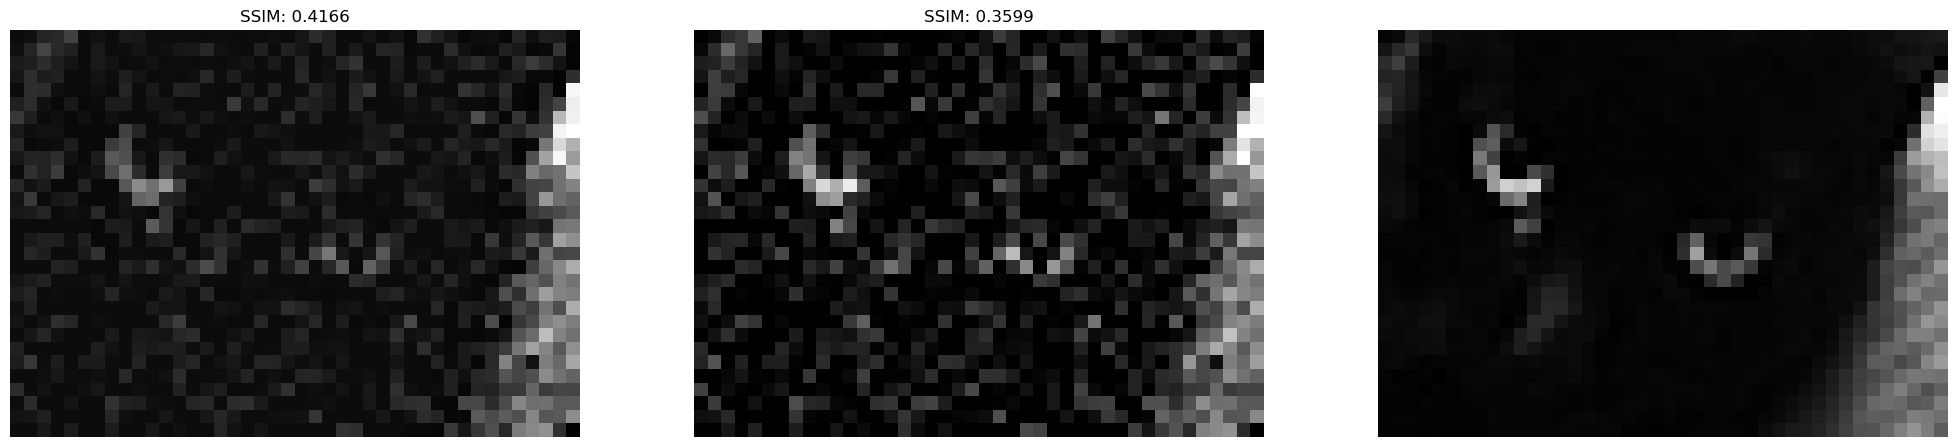

In [198]:
# Example
fig, ax = plt.subplots(1, 3, figsize=(25,7))

sub_cat_R = U_ff[5].reshape([M[5], N[5]])[20:50,-50:-8]
sub_cat_N = ff[5].reshape([M[5], N[5]])[20:50,-50:-8]
sub_cat_C = img[5].reshape([M[5], N[5]])[20:50,-50:-8]

ax[0].imshow(sub_cat_R, cmap='gray')
ax[1].imshow(sub_cat_N, cmap='gray')
ax[2].imshow(sub_cat_C, cmap='gray')

ax[0].set_title('SSIM: {0:.4f}'.format(SSIM(sub_cat_C, sub_cat_R, sub_cat_N.shape[0], sub_cat_N.shape[1]) ))
ax[1].set_title('SSIM: {0:.4f}'.format(SSIM(sub_cat_C, sub_cat_N, sub_cat_N.shape[0], sub_cat_N.shape[1]) ))

ax[0].axis('off');ax[1].axis('off');ax[2].axis('off');

In [199]:
# Summary of SSIM
print('{0:^5s}|{1:^18s}|{2:^18s}'.format('i','SSIM(u,ū)', 'SSIM(f,ū)'))
print('–'*40)
for nn in range(NN):    print('{0:^5d}|{1:^17.11g}|{2:^17.11g}'.format(nn, co[nn], cu[nn] ))
print('–'*40)
print('{0:^5s}|{1:^17.11g}|{2:^17.11g}'.format('M', np.mean(co), np.mean(cu) ))

  i  |    SSIM(u,ū)     |    SSIM(f,ū)     
––––––––––––––––––––––––––––––––––––––––
  0  |  0.52328168462  |  0.48571134556  
  1  |  0.72439282818  |  0.71196113017  
  2  |  0.53014309736  |  0.48178967529  
  3  |  0.54501700874  |  0.50137844769  
  4  |  0.52452657883  |  0.48152739919  
  5  |  0.47422961473  |   0.398712434   
  6  |  0.59567628108  |  0.56804498865  
  7  |  0.52823622633  |  0.49990138785  
  8  |  0.58770633338  |  0.55737578404  
  9  |  0.51659811177  |  0.48879342232  
 10  |  0.58364086046  |  0.56073108864  
––––––––––––––––––––––––––––––––––––––––
  M  |  0.55758623868  |  0.52144791849  


<div class="alert alert-block alert-danger">
Output
</div>

In [200]:
folder_Recovered = Path(folder).parent.as_posix() + '/Validation_Recovered_Bi-PC/'
Path(folder_Recovered).mkdir(parents=True, exist_ok=True)            # Create directory if not already available

In [201]:
Recovered_Names = ['VR_' + '0{}.png'.format(i+1) if i < 9 else 'VR_' + '{}.png'.format(i+1) for i in range(NN)]
[imwrite(folder_Recovered + Recovered_Names[nn], U_ff[nn].astype(np.uint8)) for nn in range(NN)];

---

# Other

## Test derivative map

Here I tested continuity of the forward operator by changing slightly $h$ and $\lambda$.

In [320]:
h = 0.000625/1.1
Sub_Γℓ, Sub_DΓℓ = [], []
for nn in range(NN):
    σ = h**-0.5
    Sub_Γℓ.append( W(σ, Other_Setup = 'default') );    Sub_DΓℓ.append( DW(σ, Other_Setup = 'default') )

# Although this is the right approach, we could just take advantage of the construction for 
# Sub_Γℓ to evaluate A without λ and hence compute the derivative efficiently

In [370]:
# Value of η with σ = 40.0
η

array([[34069.40040092, 34141.47618447, 34210.9973386 , ...,
        34212.49871631, 34132.1227187 , 34049.27999007]])

In [322]:
η = asarray([AKs[nn](Ones[nn]) for nn in range(NN)])
η

array([[34624.09274821, 34694.03840178, 34761.89160219, ...,
        34764.82316086, 34686.14818439, 34605.21004036]])

In [307]:
'{0:.2e}'.format(h)

'6.25e-04'

In [308]:
h, 16.59**-0.5

(0.000625, 0.24551430807011815)

In [311]:
λ = 1

In [316]:
A[0].dot(u[0])

array([-2.46797102, -1.46048172, -1.46991378, ..., -1.47610342,
       -2.48139109, -2.47007817])

Now let's see what happens when we apply the derivative:

In [347]:
Sub_Γℓ, Sub_DΓℓ = Sub_DΓℓ, Sub_Γℓ

In [348]:
η = asarray([AKs[nn](Ones[nn]) for nn in range(NN)])
η

array([[5949.28679025, 5926.98679105, 5909.45164945, ..., 5924.3352401 ,
        5942.21670949, 5962.25012276]])

In [344]:
# The derivative w.r.t. h is given by the dot product induced by this matrix without λ, but since λ is already embbeded, we could just take it off
print('⟨𝑝,∂B𝑢 - 𝜆I𝑢⟩: {0:.2f}  |  ⟨𝑢,∂B𝑝 - 𝜆I𝑝⟩: {1:.2f}  |  ⟨𝑝,∂B𝑢⟩: '.format(p[0].dot(A[0].dot(u[0]) - λ*u[0]), u[0].dot(A[0].dot(p[0]) - λ*p[0])), end='')
λ = 0.0
print('{0:.2f}'.format(p[0].dot(A[0].dot(u[0]))))

⟨𝑝,∂B𝑢 - 𝜆I𝑢⟩: -121675022.37  |  ⟨𝑢,∂B𝑝 - 𝜆I𝑝⟩: -121675022.37  |  ⟨𝑝,∂B𝑢⟩: -121675022.37


In [349]:
Sub_Γℓ, Sub_DΓℓ = Sub_DΓℓ, Sub_Γℓ

In [350]:
η = asarray([AKs[nn](Ones[nn]) for nn in range(NN)])
η

array([[34624.09274821, 34694.03840178, 34761.89160219, ...,
        34764.82316086, 34686.14818439, 34605.21004036]])

We do not need to re-instantiate the kernel!

In [360]:
h = 0.000625/1.0
Sub_Γℓ[0][0].sigma, h**-0.5

(41.95235392680606, 40.0)

In [367]:
print([ker.sigma for ker in Sub_Γℓ[0]])
[ker.__setattr__('sigma', h**-0.5) for ker in Sub_Γℓ[0]]
print([ker.sigma for ker in Sub_Γℓ[0]])

[41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606, 41.95235392680606]
[40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.

In [368]:
# Value of η with σ = 41.95235392680606
η

array([[34624.09274821, 34694.03840178, 34761.89160219, ...,
        34764.82316086, 34686.14818439, 34605.21004036]])

In [369]:
η = asarray([AKs[nn](Ones[nn]) for nn in range(NN)])
η

array([[34069.40040092, 34141.47618447, 34210.9973386 , ...,
        34212.49871631, 34132.1227187 , 34049.27999007]])

Let's see how these two modes of updating the kernel differ in terms of computational time:

In [380]:
# Timing once
h = 0.000625/1.2

start = time.time()
[W(h**-0.5, Other_Setup = 'default')]
end = time.time()
print('New object: {0:.2f}s'.format(end-start))

start = time.time()
deque((ker.__setattr__('sigma', h**-0.5) for ker in Sub_Γℓ[0]), 0)
end = time.time()
print('Inplace:    {0:.2f}s'.format(end-start))

New object: 3.02s
Inplace:    2.69s


In [383]:
h**-0.5, Sub_Γℓ[0][0].sigma

(43.81780460041329, 43.81780460041329)

---

How much precision can we expect?

In [405]:
v1 = AKs[nn](Ones[nn])
h = 0.000625/1.2 + 1e-8
deque((ker.__setattr__('sigma', h**-0.5) for ker in Sub_Γℓ[0]), 0)
v2 = AKs[nn](Ones[nn])

In [415]:
norm((v1-v2), 2.0), norm((v1-v2), np.inf)#/1e-8

(48.39262641802879, 0.33381200422809343)

Let's use a derivative estimate $\varepsilon \|\partial A(h) v\|$:

In [408]:
Sub_Γℓ, Sub_DΓℓ = Sub_DΓℓ, Sub_Γℓ

In [409]:
h = 0.000625/1.2
deque((ker.__setattr__('sigma', h**-0.5) for ker in Sub_Γℓ[0]), 0)
v3 = AKs[nn](Ones[nn])

In [413]:
norm(v3/h, 2.0) * 1e-8, norm(v3/h, np.inf) * 1e-8

(48.393361878164505, 0.3338164273270735)

In [417]:
norm(v3/h, 2.0)/norm(Ones[nn])

14658935.342046373

We can use this definition of condition number:  $$ \mathrm{cond}(Av)(h) = \| \partial A(h)v \| \big/ \|A(h) v\|/ h $$

In [429]:
norm(v3)/(norm(v1)/h)

0.00019005215155731828

In [418]:
Sub_Γℓ, Sub_DΓℓ = Sub_DΓℓ, Sub_Γℓ

In [425]:
Sub_Γℓ[0][0]._kernel, Sub_DΓℓ[0][0]._kernel

(1, 2)

## Shared memory test

Little test of memory:

In [116]:
rng = default_rng(10)
Z = rng.normal(0, 1, [30,3])

In [117]:
def W(σ, n = 64, m = 8, p = 8, Other_Setup = None):
    # Setup approximation parameters
    NFFT_setup = fastadj.AccuracySetup(n,m,p,0,0)   if Other_Setup is None else   Other_Setup
    return [fastadj.AdjacencyMatrix(Z, σ, NFFT_setup, 0.0) for l in range(2)]

def AK(u):
    # Apply matrix-vector multiplication
    AKu = np.zeros_like(u)
    for l in range(2):
        AKu += SubKernels[l].apply(u)
    # Multiply each subKernel by its weight and collect into a sum
    AKu *= 0.5
    return AKu

In [118]:
SubKernels = W(σ, Other_Setup = 'fine')

In [119]:
AK(ones(30))

array([28.88670667, 28.91892454, 28.83752897, 28.91410322, 28.91855006,
       28.81735135, 28.90619944, 28.85331717, 28.84474194, 28.80646189,
       28.83609118, 28.80397848, 28.88742006, 28.92211151, 28.88883769,
       28.84519289, 28.88707701, 28.91959674, 28.76553612, 28.91875104,
       28.88151133, 28.77101363, 28.92207385, 28.87849062, 28.9087072 ,
       28.86684557, 28.92280579, 28.91753665, 28.70298851, 28.81351775])

In [120]:
Mat_NFST  = np.apply_along_axis(SubKernels[0].apply, 0, np.eye(30))
Mat_NFST += np.apply_along_axis(SubKernels[1].apply, 0, np.eye(30))
Mat_NFST *= 0.5

In [121]:
np.fill_diagonal(Mat_NFST, 1.0) # Just for checking visually

Let's modify ```Z``` and see if the matrix changes:

In [123]:
Z = 2 * rng.normal(0, 1, [30,3])

First we can check that the final degree vector does not change:

In [124]:
AK(ones(30))

array([28.88670667, 28.91892454, 28.83752897, 28.91410322, 28.91855006,
       28.81735135, 28.90619944, 28.85331717, 28.84474194, 28.80646189,
       28.83609118, 28.80397848, 28.88742006, 28.92211151, 28.88883769,
       28.84519289, 28.88707701, 28.91959674, 28.76553612, 28.91875104,
       28.88151133, 28.77101363, 28.92207385, 28.87849062, 28.9087072 ,
       28.86684557, 28.92280579, 28.91753665, 28.70298851, 28.81351775])

Now let's obtain the intermediate kernels explicitly and assemble the matrix:

In [125]:
bMat_NFST  = np.apply_along_axis(SubKernels[0].apply, 0, np.eye(30))
bMat_NFST += np.apply_along_axis(SubKernels[1].apply, 0, np.eye(30))
bMat_NFST *= 0.5
np.fill_diagonal(bMat_NFST, 1.0) # Just for checking visually

In [126]:
np.count_nonzero(bMat_NFST-Mat_NFST)

0

Ok, the memory is not shared through ```Z```. Now let's repeat it through a list just to be extra sure:

In [127]:
Sub_Γℓ = [SubKernels, None]

In [128]:
def AK_n(nn):
    def AK(u):
        # Apply matrix-vector multiplication
        AKu = np.zeros_like(u)
        for l in range(2):
            AKu += Sub_Γℓ[nn][l].apply(u)
        # Multiply each subKernel by its weight and collect into a sum
        AKu *= 0.5
        return AKu
    return AK

In [129]:
Sub_Γℓ[1] = W(σ, Other_Setup = 'fine')     # Created with the new Z

In [130]:
AKs = [AK_n(nn) for nn in range(2)]

In [131]:
AKs[0](ones(30)), AKs[1](ones(30))

(array([28.88670667, 28.91892454, 28.83752897, 28.91410322, 28.91855006,
        28.81735135, 28.90619944, 28.85331717, 28.84474194, 28.80646189,
        28.83609118, 28.80397848, 28.88742006, 28.92211151, 28.88883769,
        28.84519289, 28.88707701, 28.91959674, 28.76553612, 28.91875104,
        28.88151133, 28.77101363, 28.92207385, 28.87849062, 28.9087072 ,
        28.86684557, 28.92280579, 28.91753665, 28.70298851, 28.81351775]),
 array([28.38383547, 28.53096327, 27.9903928 , 28.16730769, 28.36223936,
        28.17538931, 28.42809806, 27.60817825, 28.10744958, 28.02949951,
        27.79640521, 28.43166307, 28.16155282, 27.8923602 , 28.35373057,
        28.30820589, 28.43129605, 28.43463205, 28.31047252, 27.86731509,
        27.85331211, 28.52534351, 28.00514614, 27.87570056, 28.34103648,
        27.86136485, 27.51789082, 28.05521782, 27.62156488, 28.47901169]))

Since ```AK``` depended on ```SubKernels```, it was sharing memory, so we implemented a function that processes the matrix vector multiplication separatedly after each subkernel has been defined properly in memory.

## Parallelising the matrix vector multiplication

Below we implement the operation $ \left( \sum\limits_{\ell=1}^{\mathsf{L}} \Gamma_{\ell,i} u_{i} \right)_{i \in 1:N}$ in parallel.

### First, we parallelise $ \left( \Gamma_{\ell,i} u_{i} \right)_{\ell \in 1:\mathsf{L}, i \in 1:N}$:

The following configuration is needed for preventing issues with the parallel library and MacOs:

In [28]:
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp                                                                                     
mp.set_start_method("fork")
mp_fork = mp.get_context('fork')

In [22]:
Ones = [ones(M[nn] * N[nn]) for nn in range(NN)]

In [43]:
# Function to be executed in parallel
def compute_vector(nn, l, u):
    """Apply the function Sub_Γℓ[nn][l] to u[nn]"""
    #return funs[nn][l](u)
    return Sub_Γℓ[nn][l].apply(u)

In [34]:
funs = [[sum for l in range(num_windows[nn])] for nn in range(NN)]

In [35]:
# Initialize a structure to hold the results
results = [[None for l in range(num_windows[nn])] for nn in range(NN)]

In [44]:
with concurrent.futures.ProcessPoolExecutor(max_workers=1, mp_context=mp_fork) as executor:
    # Create all possible (nn, l) pairs and execute them in parallel
    future_to_indices = {executor.submit(compute_vector, nn, l, Ones[nn]): (nn, l) for nn in range(NN) for l in range(num_windows[nn])}
    
    # Collect the results as they complete
    for future in concurrent.futures.as_completed(future_to_indices):
        nn, l = future_to_indices[future]
        try:
            results[nn][l] = future.result()
        except Exception as e:
            print(f"An error occurred at (nn={nn}, l={l}): {e}")

In [60]:
results = asarray([np.sum(results[nn], 0) * k_weight[nn] for nn in range(NN)])

In [68]:
[np.count_nonzero((results - η)[nn]) for nn in range(NN)]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

That test was serial, let's divide:

In [83]:
start = time.time()

# Initialize a structure to hold the results
results = [[None for l in range(num_windows[nn])] for nn in range(NN)]
with concurrent.futures.ProcessPoolExecutor(max_workers=2, mp_context=mp_fork) as executor:
    # Create all possible (nn, l) pairs and execute them in parallel
    future_to_indices = {executor.submit(compute_vector, nn, l, Ones[nn]): (nn, l) for nn in range(NN) for l in range(num_windows[nn])}
    
    # Collect the results as they complete
    for future in concurrent.futures.as_completed(future_to_indices):
        nn, l = future_to_indices[future]
        try:
            results[nn][l] = future.result()
        except Exception as e:
            print(f"An error occurred at (nn={nn}, l={l}): {e}")

end = time.time()
print('Parallel application - 2: {0:.2f} s'.format( end - start ))

# Again:

start = time.time()
# Initialize a structure to hold the results
results = [[None for l in range(num_windows[nn])] for nn in range(NN)]
with concurrent.futures.ProcessPoolExecutor(max_workers=3, mp_context=mp_fork) as executor:
    # Create all possible (nn, l) pairs and execute them in parallel
    future_to_indices = {executor.submit(compute_vector, nn, l, Ones[nn]): (nn, l) for nn in range(NN) for l in range(num_windows[nn])}
    
    # Collect the results as they complete
    for future in concurrent.futures.as_completed(future_to_indices):
        nn, l = future_to_indices[future]
        try:
            results[nn][l] = future.result()
        except Exception as e:
            print(f"An error occurred at (nn={nn}, l={l}): {e}")

end = time.time()
print('Parallel application - 3: {0:.2f} s'.format( end - start ))

# Once more

start = time.time()
# Initialize a structure to hold the results
results = [[None for l in range(num_windows[nn])] for nn in range(NN)]
with concurrent.futures.ProcessPoolExecutor(max_workers=8, mp_context=mp_fork) as executor:
    # Create all possible (nn, l) pairs and execute them in parallel
    future_to_indices = {executor.submit(compute_vector, nn, l, Ones[nn]): (nn, l) for nn in range(NN) for l in range(num_windows[nn])}
    
    # Collect the results as they complete
    for future in concurrent.futures.as_completed(future_to_indices):
        nn, l = future_to_indices[future]
        try:
            results[nn][l] = future.result()
        except Exception as e:
            print(f"An error occurred at (nn={nn}, l={l}): {e}")

end = time.time()
print('Parallel application - 8: {0:.2f} s'.format( end - start ))

# One last time but with the number of images

start = time.time()
# Initialize a structure to hold the results
results = [[None for l in range(num_windows[nn])] for nn in range(NN)]
with concurrent.futures.ProcessPoolExecutor(max_workers=15, mp_context=mp_fork) as executor:
    # Create all possible (nn, l) pairs and execute them in parallel
    future_to_indices = {executor.submit(compute_vector, nn, l, Ones[nn]): (nn, l) for nn in range(NN) for l in range(num_windows[nn])}
    
    # Collect the results as they complete
    for future in concurrent.futures.as_completed(future_to_indices):
        nn, l = future_to_indices[future]
        try:
            results[nn][l] = future.result()
        except Exception as e:
            print(f"An error occurred at (nn={nn}, l={l}): {e}")

end = time.time()
print('Parallel application - 15: {0:.2f} s'.format( end - start ))

Parallel application - 2: 4.45 s
Parallel application - 3: 2.54 s
Parallel application - 8: 1.43 s
Parallel application - 15: 1.52 s


In [80]:
results = asarray([np.sum(results[nn], 0) * k_weight[nn] for nn in range(NN)])
[np.count_nonzero((results - η)[nn]) for nn in range(NN)]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

We know we can reduce things down to less than a second because:

In [133]:
start = time.time()
[AKs[nn]( ones(M[nn] * N[nn]) ) for nn in [0]]
end = time.time()
print('One kernel in sequential application: {0:.2f} s'.format( end - start ))

start = time.time()
[Sub_Γℓ[nn][0].apply( ones(M[nn] * N[nn]) ) for nn in [0]]
end = time.time()
print('One subkernel application: {0:.2f} s'.format( end - start ))

One kernel in sequential application: 0.48 s
One subkernel application: 0.03 s


We currently cannot reach this time due to computational constraints. If we had a machine with $N\times \mathsf{L}$ cores, we would be able to reduce the time to just one matrix vector multiplication; i.e., 0.03 s. With $\mathsf{L}$ cores, the time goes up by 17 times to approximately 0.48 s.
In our case, we have 8 cores the Apple M1, hence we cannot go below the 1 s mark.

---

### Let us now proceed with the summation as an additional step:

In [27]:
# Function to be executed in parallel
def compute_vector(nn, l, u):
    """Apply the function Sub_Γℓ[nn][l] to u[nn]"""
    #return funs[nn][l](u)
    return Sub_Γℓ[nn][l].apply(u)

In [58]:
nn = 1

In [59]:
# Initialize a structure to hold the results
results = empty([num_windows[nn], nm_s[nn]])

start = time.time()
with concurrent.futures.ProcessPoolExecutor(max_workers=1, mp_context=mp_fork) as executor:
    # Create all possible (nn, l) pairs and execute them in parallel
    future_to_indices = {executor.submit(compute_vector, nn, l, Ones[nn]): (nn, l) for l in range(num_windows[nn])}
    
    # Collect the results as they complete
    for future in concurrent.futures.as_completed(future_to_indices):
        nn, l = future_to_indices[future]
        try:
            results[l] = future.result()
        except Exception as e:
            print(f"An error occurred at (nn={nn}, l={l}): {e}")
# 
end = time.time()
print('Parallel application - 1: {0:.2f} s'.format( end - start ))
AKu = results.sum(0) * k_weight[nn]

start = time.time()
with concurrent.futures.ProcessPoolExecutor(max_workers=2, mp_context=mp_fork) as executor:
    # Create all possible (nn, l) pairs and execute them in parallel
    future_to_indices = {executor.submit(compute_vector, nn, l, Ones[nn]): (nn, l) for l in range(num_windows[nn])}
    
    # Collect the results as they complete
    for future in concurrent.futures.as_completed(future_to_indices):
        nn, l = future_to_indices[future]
        try:
            results[l] = future.result()
        except Exception as e:
            print(f"An error occurred at (nn={nn}, l={l}): {e}")
# 
end = time.time()
print('Parallel application - 2: {0:.2f} s'.format( end - start ))

start = time.time()
with concurrent.futures.ProcessPoolExecutor(max_workers=3, mp_context=mp_fork) as executor:
    # Create all possible (nn, l) pairs and execute them in parallel
    future_to_indices = {executor.submit(compute_vector, nn, l, Ones[nn]): (nn, l) for l in range(num_windows[nn])}
    
    # Collect the results as they complete
    for future in concurrent.futures.as_completed(future_to_indices):
        nn, l = future_to_indices[future]
        try:
            results[l] = future.result()
        except Exception as e:
            print(f"An error occurred at (nn={nn}, l={l}): {e}")
# 
end = time.time()
print('Parallel application - 3: {0:.2f} s'.format( end - start ))

start = time.time()
with concurrent.futures.ProcessPoolExecutor(max_workers=8, mp_context=mp_fork) as executor:
    # Create all possible (nn, l) pairs and execute them in parallel
    future_to_indices = {executor.submit(compute_vector, nn, l, Ones[nn]): (nn, l) for l in range(num_windows[nn])}
    
    # Collect the results as they complete
    for future in concurrent.futures.as_completed(future_to_indices):
        nn, l = future_to_indices[future]
        try:
            results[l] = future.result()
        except Exception as e:
            print(f"An error occurred at (nn={nn}, l={l}): {e}")
# 
end = time.time()
print('Parallel application - 8: {0:.2f} s'.format( end - start ))

start = time.time()
with concurrent.futures.ProcessPoolExecutor(max_workers=17, mp_context=mp_fork) as executor:
    # Create all possible (nn, l) pairs and execute them in parallel
    future_to_indices = {executor.submit(compute_vector, nn, l, Ones[nn]): (nn, l) for l in range(num_windows[nn])}
    
    # Collect the results as they complete
    for future in concurrent.futures.as_completed(future_to_indices):
        nn, l = future_to_indices[future]
        try:
            results[l] = future.result()
        except Exception as e:
            print(f"An error occurred at (nn={nn}, l={l}): {e}")
# 
end = time.time()
print('Parallel application - 17: {0:.2f} s'.format( end - start ))

Parallel application - 1: 1.08 s
Parallel application - 2: 0.20 s
Parallel application - 3: 0.16 s
Parallel application - 8: 0.12 s
Parallel application - 17: 0.15 s


In [86]:
def AK_n(nn):
    # Outer function selects the index nn and prepares the evaluator
    results = empty([num_windows[nn], nm_s[nn]])        # Initialize a structure to hold the results
    def AK(u):
        nonlocal nn  # Declare that nn is not a local variable
        """
        Approximate the matrix-vector product AK*u, where AK = w * (K_1 + K_2 + ... + K_L).

        Note
        ----
        Since this function serves a LinearOperator from scipy, only one variable can be passed as input parameter.
        Any other variable needed has to be global, so that they can still be used within this function

        Parameters
        ----------
        u : ndarray
            The vector, whose product AK*u with the matrix AK shall be approximated.

        Returns
        -------
        AKu : ndarray
            The approximated matrix-vector product AK*u.
        """
        
        # Apply matrix-vector multiplication in parallel
        with ProcessPoolExecutor(max_workers=8, mp_context=mp_fork) as executor:
            # Create all possible (nn, l) pairs and execute them in parallel
            futures = {executor.submit(compute_vector, nn, l, u): (nn, l) for l in range(num_windows[nn])}

            # Collect the results as they complete
            for future in concurrent.futures.as_completed(futures):
                nn, l = futures[future]
                try:
                    results[l] = future.result()
                except Exception as e:
                    print(f"An error occurred at (nn={nn}, l={l}): {e}")
        
        # Add up products and weight
        AKu = results.sum(0) * k_weight[nn]
        
        return AKu
    return AK

In [100]:
start = time.time()
ηᴾ = [AK_n(nn)(Ones[nn]) for nn in range(NN)]
end = time.time()
print('Parallel application - 8: {0:.2f} s'.format( end - start ))

Parallel application - 8: 2.47 s


In [103]:
[np.count_nonzero((η - ηᴾ)[nn]) for nn in range(NN)]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Computing exact bounds on distances:

In [26]:
from sklearn.neighbors import KDTree
from sklearn.metrics import pairwise_distances, pairwise_distances_chunked
from scipy.spatial import ConvexHull

def compute_min_and_max_distances(F):
    """
    Compute the smallest nonzero distance and largest distance between rows of a matrix F.
    
    Parameters:
    -----------
    F : A 2D numpy array of shape (n, k) where rows represent points in R^k.

    Returns:
    --------
    tuple (min_nonzero_dist, max_dist)
        - min_nz_dist: smallest nonzero Euclidean distance between any two rows
        - max_dist: largest Euclidean distance between any two rows
    """
    # Part 1: Compute the smallest nonzero distance using a KDTree
    if F.shape[1] == 1:
        diffs = np.diff(np.sort(F.ravel()))                                            # F is 1-dim, we can just sort and determine the smallest consecutive
        min_nz_dist = diffs[diffs > 0.0].min()                                         # difference
    else:
        tree = KDTree(F)                                                               # Build KDTree
        distances, _ = tree.query(F, k = 2, sort_results = False)                      # Find distance to the nearest neighbor
        min_nz_dist  = np.ma.masked_equal(distances.ravel(), 0.0, copy=False).min()    # Exclude 0 distances

    # Part 2: Compute the maximum distance using convex hull
    if F.shape[1] == 1:
        max_dist = (F.max() - F.min())
    else:
        hull = ConvexHull(F);    hull_vertices = hull.points[hull.vertices]            # Extract hull vertices

        # Compare all pairs of vertices on the convex hull
        if hull_vertices.shape[0] <= 100:
            # Do a direct computation for small dimensions
            max_dist = pairwise_distances(hull_vertices, metric='euclidean', n_jobs=-1, force_all_finite=False).max()
        else:
            # Process distances in chunks so that they fit in memory
            max_dist = 0.0        # Initialise maximum distance
            for chunk in pairwise_distances_chunked(hull_vertices, metric='euclidean', n_jobs=-1, working_memory=256, reduce_func=None):
                # Find the maximum distance in the current chunk
                max_dist = max(max_dist, chunk.max())
    
    return min_nz_dist, max_dist

In [27]:
Window_mM_Distances = asarray([ compute_min_and_max_distances(X[:,windows[l]]) for l in range(num_windows[nn])])

In [28]:
# Image | Minimum: The last one to vanish & the first one to vanish
print('{0:2d} | {1:.2e} {2:.2e} | {3:.2f} {4:.2f}'.format(nn, Window_mM_Distances[:,0].min(), Window_mM_Distances[:,0].max(),
                                                              Window_mM_Distances[:,1].min(), Window_mM_Distances[:,1].max() ) )

 0 | 1.00e+00 1.00e+00 | 255.00 441.67


The smallest nonzero distance is $1$, while the largest distance is close to $\sqrt{3} (255)$. 

In [31]:
# Error of bounds
1.0 - Window_mM_Distances[:,0].min(), np.sqrt(3) * 255.0 - Window_mM_Distances[:,1].max()

(2.842170943040401e-14, -5.684341886080802e-14)

---